# Modeling

# Importing Packages

In [42]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import json
import numpy as np

from IPython.display import clear_output, display_html, Markdown, display
import time
from tqdm.notebook import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor
from statsmodels.regression import linear_model as lr

import joblib

In [43]:
def linear_model(x, y):
    
    """
    1) Performs a train-test split.
    2) Initializes a linear regression model.
    3) Fits the model.
    4) Sorts coefficients into positive and negative.
    5) Calculates predictions for train and test sets.
    6) Calculates MAE and RMSE error metrics for both sets of predictions.
    7) Calculates residuals for both sets of predictions.
    8) Returns a dictionary with all this information.
    """
    
    # Train-test split
    state = 42
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=state, test_size=0.2)
    target = y.name
    formula = f"{target} ~ " + ' + '.join([col for col in X.columns])

    # Fits model
    base_model = lr.OLS.from_formula(formula, data=pd.concat([y_train, X_train], axis=1))
    results = base_model.fit(disp=True)

    # Sorts coefficients into positive and negative
    results_as_html = results.summary().tables[1].as_html()
    coefficients_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    coefficients_df.columns = ['coef', 'std_err', 't', 'p_of_t', 'cf_lower', 'cf_upper']
    positive_words = coefficients_df.query('coef>0 & p_of_t<0.05').sort_values(by='coef', ascending=True)
    negative_words = coefficients_df.query('coef<0 & p_of_t<0.05').sort_values(by='coef', ascending=True)

    # Calculates train and test predictions
    train_predictions = results.predict(X_train)
    test_predictions = results.predict(X_test)

    # Calculates error metrics for both sets of predictions
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    # Calculates residuals for both sets of predictions
    test_residuals = test_predictions.sub(y_test)
    train_residuals = train_predictions.sub(y_train)
    
    # Calculates r squared for both sets of predictions
    test_r2 = r2_score(y_test, test_predictions)
    train_r2 = r2_score(y_train, train_predictions)

    return  {'x_train': X_train, 
            'y_train': y_train, 
            'x_test': X_test, 
            'y_test': y_test, 
            'coefficients': coefficients_df, 
            'positive_words': positive_words, 
            'negative_words': negative_words, 
            'train_predictions': train_predictions, 
            'test_predictions': test_predictions, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_rmse': train_rmse, 
            'test_rmse': test_rmse, 
            'train_r2': train_r2, 
            'test_r2': test_r2,
            'train_residuals': train_residuals, 
            'test_residuals': test_residuals, 
            'results': results}

In [44]:
def top_words(results):
    
    """
    Takes in a dictionary returned by the linear_model function above.
    Returns a visualization of the top 20 positive and negative words.
    """
    positive_words = results['positive_words'].sort_values(by='coef', ascending=True).tail(20)
    negative_words = results['negative_words'].sort_values(by='coef', ascending=False).tail(20)

    fig, axes = plt.subplots(1,2, figsize=(15,10))
    axes[0].set_title("Top positive words")
    axes[0].barh(positive_words.index, positive_words.coef.head(20))
    axes[1].set_title("Top negative words")
    axes[1].barh(negative_words.index, negative_words.coef.head(20))
    axes[1].tick_params(axis='y', direction='inout', labelright=True, labelleft=False);

In [45]:
def plot_r2(results):
    
    """
    Plots visualizations for the R-squared for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_r2 = round(results['train_r2'], 3)
    test_r2 = round(results['test_r2'], 3)

    fig,ax = plt.subplots(figsize=(5,5))
    
    barplot = ax.bar(['Train R2', 'Test R2'], [train_r2, test_r2])
    ax.set_title("R2")
    ax.bar_label(barplot, 
                      labels=[train_r2, test_r2], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

In [97]:
def plot_error(results):
    
    """
    Plots visualizations for the MAE and r2 metrics for train and test predictions.
    """
    
    # Rounds metrics to 3 decimal places for aesthetics
    train_mae = round(results['train_mae'], 3)
    test_mae = round(results['test_mae'], 3)
    train_r2 = round(results['train_r2'], 3)
    test_r2 = round(results['test_r2'], 3)

    fig,axes = plt.subplots(1,2, figsize=(20,5))
    
    barplot = axes[0].bar(['Train MAE', 'Test MAE'], [train_mae, test_mae])
    axes[0].set_title("Mean Absolute Errors")
    axes[0].bar_label(barplot, 
                      labels=[train_mae, test_mae], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');

    barplot = axes[1].bar(['Train R-squared', 'Test R-squared'], [train_r2, test_r2])
    axes[1].bar_label(barplot, 
                      labels=[train_r2, test_r2], 
                      label_type='center', 
                      color='white', 
                      fontsize='20');
    
    axes[1].set_title("R-Squared Values");

In [47]:
def actual_predicted(results, line=True):
    
    """
    1)
    Plots actual values against predicted values.
    The scatter plot is supposed to fall along the x=y line.
    If you want this line to see how good model predictions are, set line=True.
    If you find this line distracting, set line=False.
    
    2)
    Plots aggregated actual and predicted values across time.
    """
    
    train_predictions = results['train_predictions'].copy()
    test_predictions = results['test_predictions'].copy()
    y_train = results['y_train'].copy()
    y_test = results['y_test'].copy()

    
    # Sets index to date-time for aggregated plots
    train_predictions = train_predictions.sort_index()
    train_predictions.index = dates[dates.index.isin(train_predictions.index)]
    test_predictions = test_predictions.sort_index()
    test_predictions.index = dates[dates.index.isin(test_predictions.index)]
    y_train = y_train.sort_index()
    y_train.index = dates[dates.index.isin(y_train.index)]
    y_test = y_test.sort_index()
    y_test.index = dates[dates.index.isin(y_test.index)]

    # Scatterplot #1
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(y_test, test_predictions, alpha=0.002, s=10)
    if line:
        ax.scatter(np.linspace(y_test.min(), y_test.max(),1000), 
                   np.linspace(y_test.min(), y_test.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title("Test values vs. test predictions");
    
    
    # Scatterplot #2
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(y_train, train_predictions, alpha=0.002, s=10)
    if line:
        ax.scatter(np.linspace(y_train.min(), y_train.max(),1000),
                   np.linspace(y_train.min(), y_train.max(),1000), 
                   color="black", 
                   s=0.25)
    ax.set_title("Train values vs. train predictions");

    
    # Aggregated plot #1
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    axes[0].plot(\
                 train_predictions[(train_predictions.index>'2016-02-01') & 
                                   (train_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    
    axes[0].plot(\
                 y_train[(y_train.index>'2016-02-01') &
                         (y_train.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[0].set_title("Train predictions vs. train values")
    axes[0].legend();
    
    
    # Aggregated plot #2
    axes[1].plot(\
                 test_predictions[(test_predictions.index>'2016-02-01') & 
                                  (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='predicted')
    axes[1].plot(\
                 y_test[(test_predictions.index>'2016-02-01') & 
                        (test_predictions.index<'2020-01-01')]\
                 .groupby(pd.Grouper(freq='1M')).mean(), label='original')
    axes[1].set_title("Test predictions vs. test values")
    axes[1].legend();

In [48]:
def residuals(results):
    """
    1) Graphs a histogram for test and train residuals.
    2) Graphs a scatterplot over time for test and train residuals.
    """
    
    train_residuals = results['train_residuals']
    test_residuals = results['test_residuals']
    
    train_residuals = train_residuals.sort_index()
    train_residuals.index = dates[dates.index.isin(train_residuals.index)]
    test_residuals = test_residuals.sort_index()
    test_residuals.index = dates[dates.index.isin(test_residuals.index)]
    
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].hist(train_residuals, bins=100)
    axes[0].set_title("Train residuals")
    axes[1].hist(test_residuals, bins=100)
    axes[1].set_title("Test residuals");
    
    train_residuals = train_residuals[\
                                      (train_residuals.index>'2016-02-01') & 
                                      (train_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    test_residuals = test_residuals[\
                                    (test_residuals.index>'2016-02-01') & 
                                    (test_residuals.index<'2020-01-01')]\
                                    .groupby(pd.Grouper(freq='1H')).mean()
    
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    axes[0].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[0].set_title("Train residuals over time")
    axes[1].scatter(train_residuals.index, train_residuals, alpha=0.005)
    axes[1].set_title("Test residuals over time");

In [99]:
def analyze_model(results, line=True):
    plot_error(results)
    top_words(results)
    actual_predicted(results, line=line)
    residuals(results)

In [50]:
def gridsearch(X, y):
    
    """
    Conducts a grid search for "alpha" and "penalty" parameters
    in a linear regression model.
    
    Returns:
    
    1) Best parameters found
    2) Best MAE score
    3) Best estimator's MAE score on test data
    4) All the coefficients of the best estimator
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    param_grid = {
        'alpha': [0.0001, 0.001, 0.01],
        'penalty': ['l1', 'l2', 'elasticnet'],
    }

    sgd_reg = SGDRegressor(max_iter=10000, tol=1e-3)
    grid_search = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2)
    grid_search.fit(X_train, y_train)

    clear_output()

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    best_model = grid_search.best_estimator_
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, train_predictions) 
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    train_r2 = r2_score(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)

    coefficients_df = pd.DataFrame({'gram': X_train.columns, 
                                    'coef': best_model.coef_}).sort_values(by='coef', ascending=True)
    
    return {'best_params': best_params, 
            'best_score': best_score, 
            'coefficients': coefficients_df, 
            'train_mae': train_mae, 
            'test_mae': test_mae, 
            'train_r2': train_r2, 
            'test_r2': test_r2, 
            'train_predictions': train_predictions,
            'test_predictions': test_predictions}

# Importing data

In [51]:
name='the_donald_comments'

In [53]:
targets = pd.read_parquet(path=f'../data/training_data/{name}_targets.parquet')

unigram_features = pd.read_parquet(path=f'../data/training_data/{name}_unigram_features.parquet')
bigram_features = pd.read_parquet(path=f'../data/training_data/{name}_bigram_features.parquet')
trigram_features = pd.read_parquet(path=f'../data/training_data/{name}_trigram_features.parquet')

dates = targets.date
scores = targets.score
vader = targets.vader

In [12]:
X = unigram_features
y = scores[scores.index.isin(X.index)]
print(f"Average post score: {y.mean()}")

Average post score: 7.223243658379662


In [13]:
model1_results = linear_model(X, y)

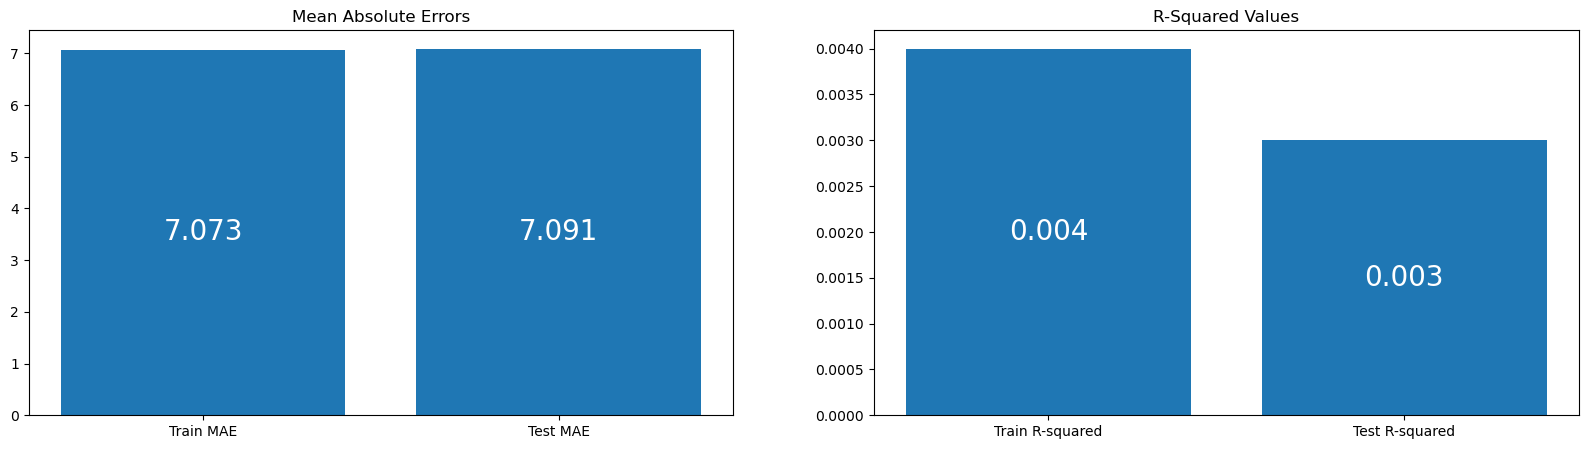

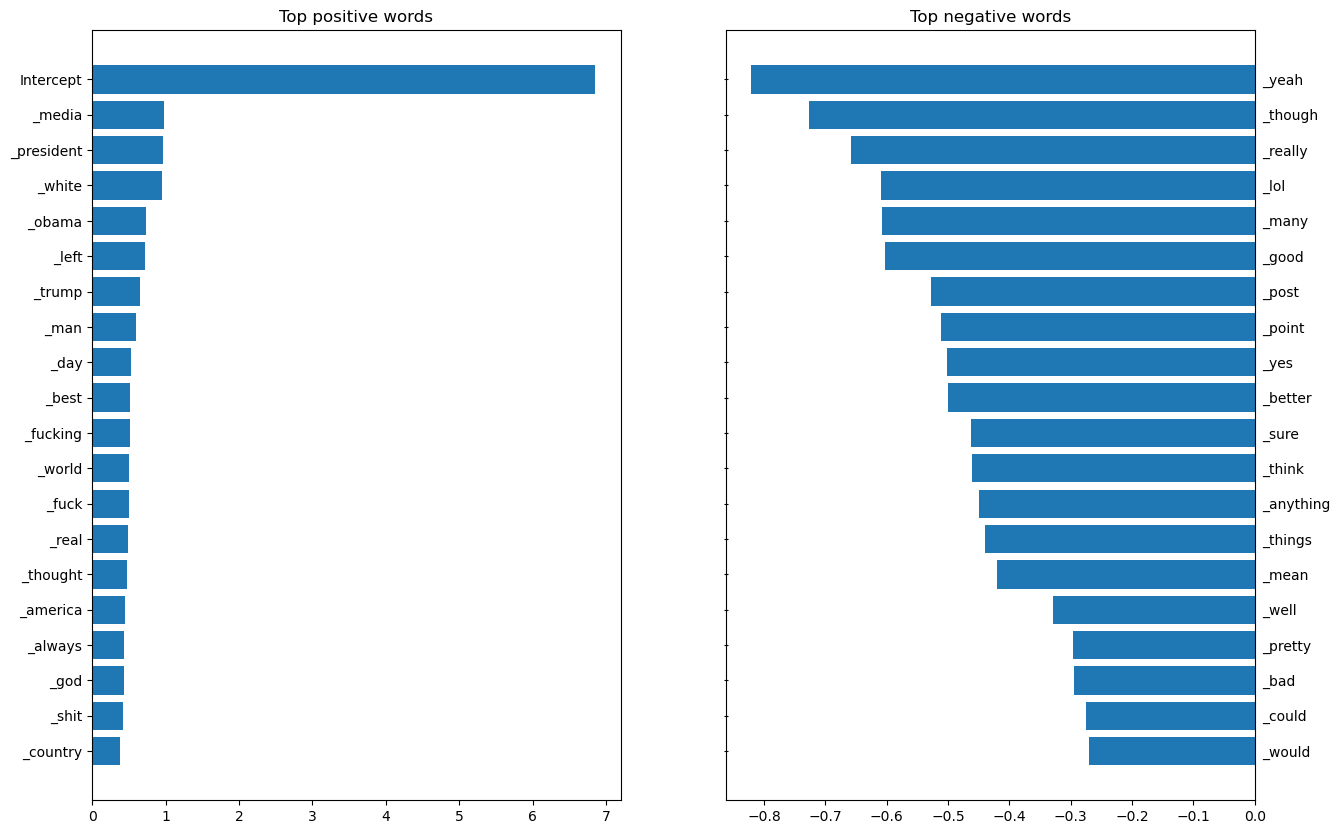

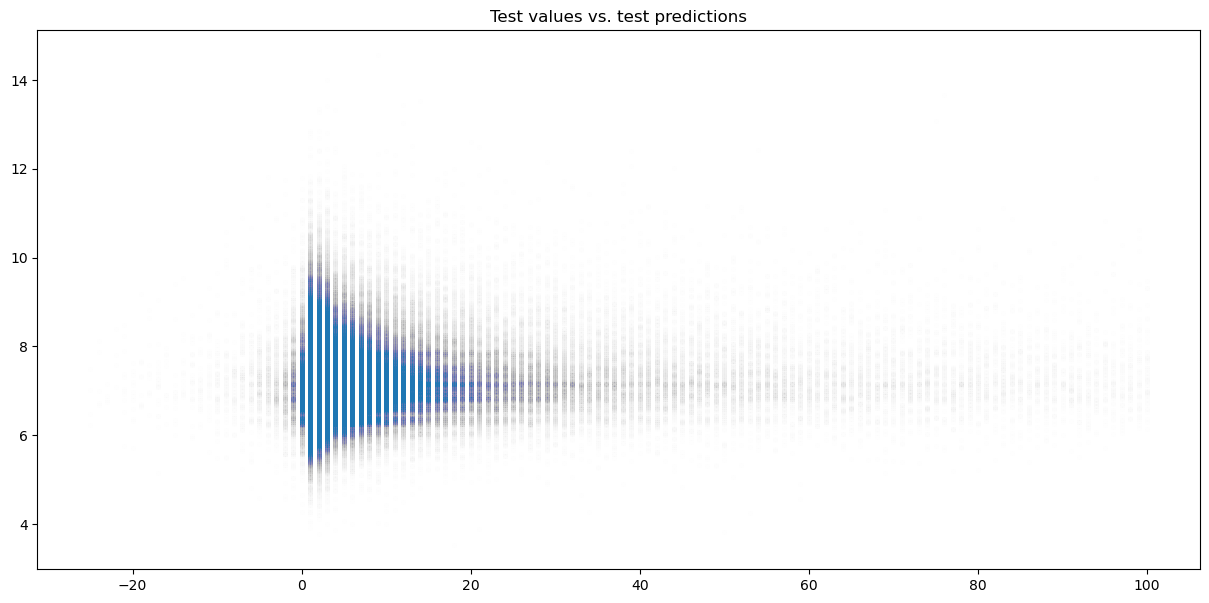

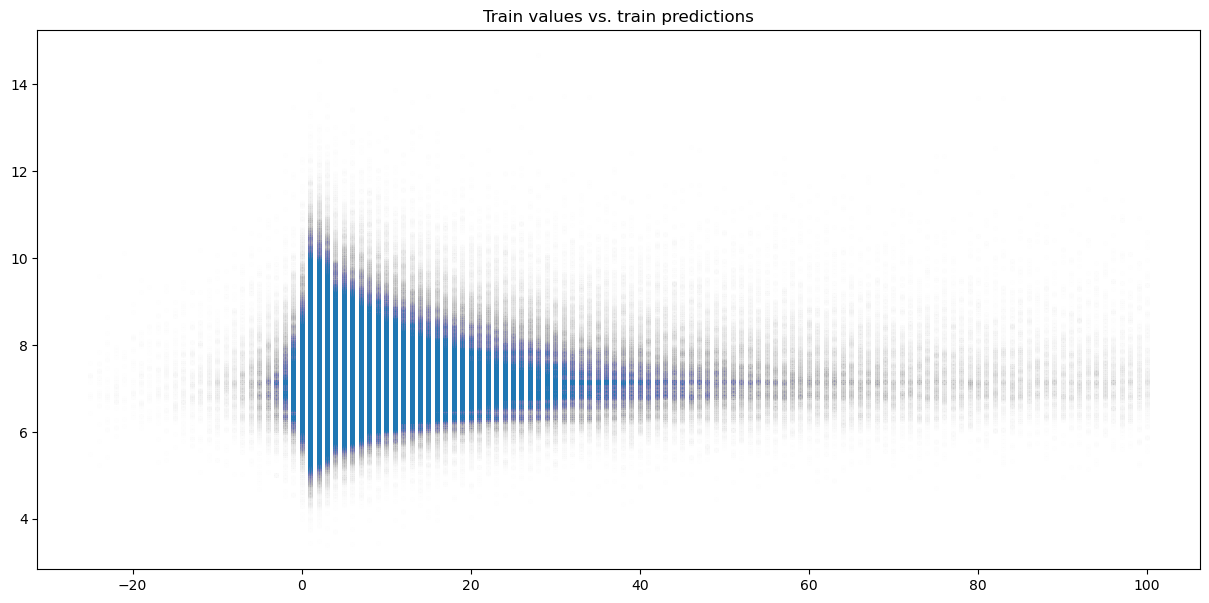

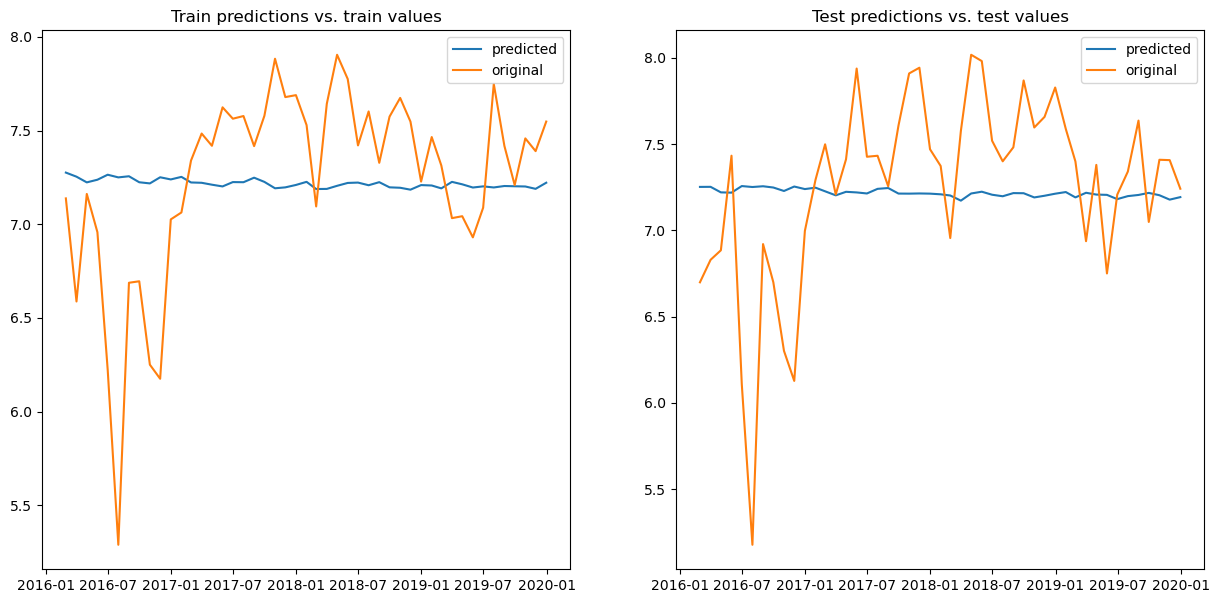

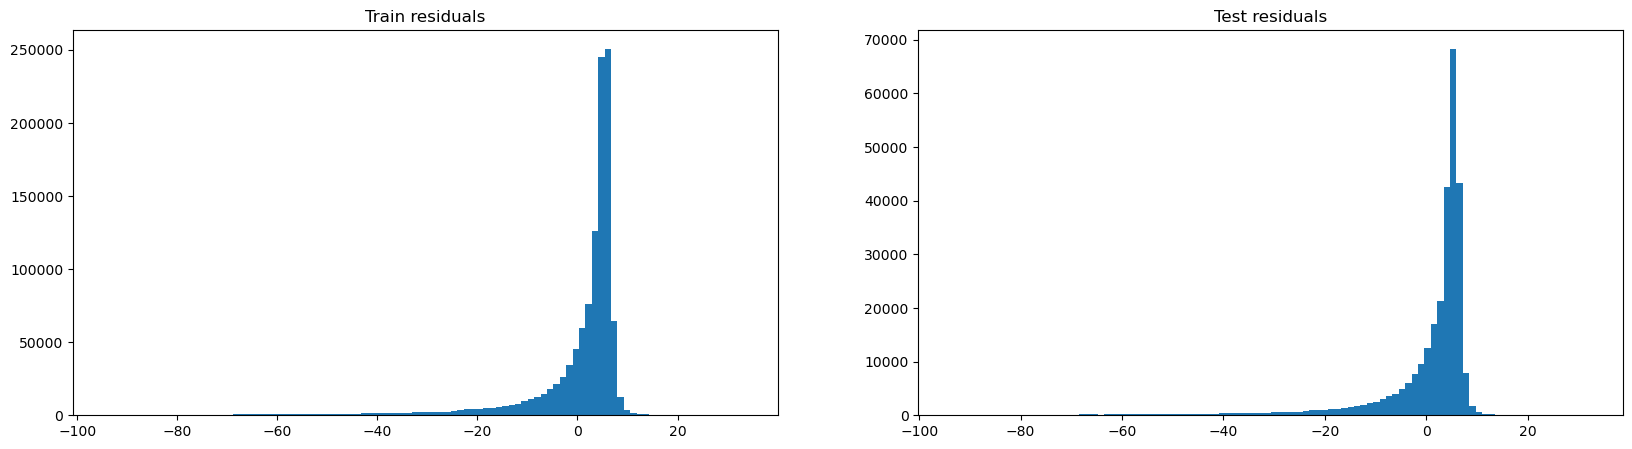

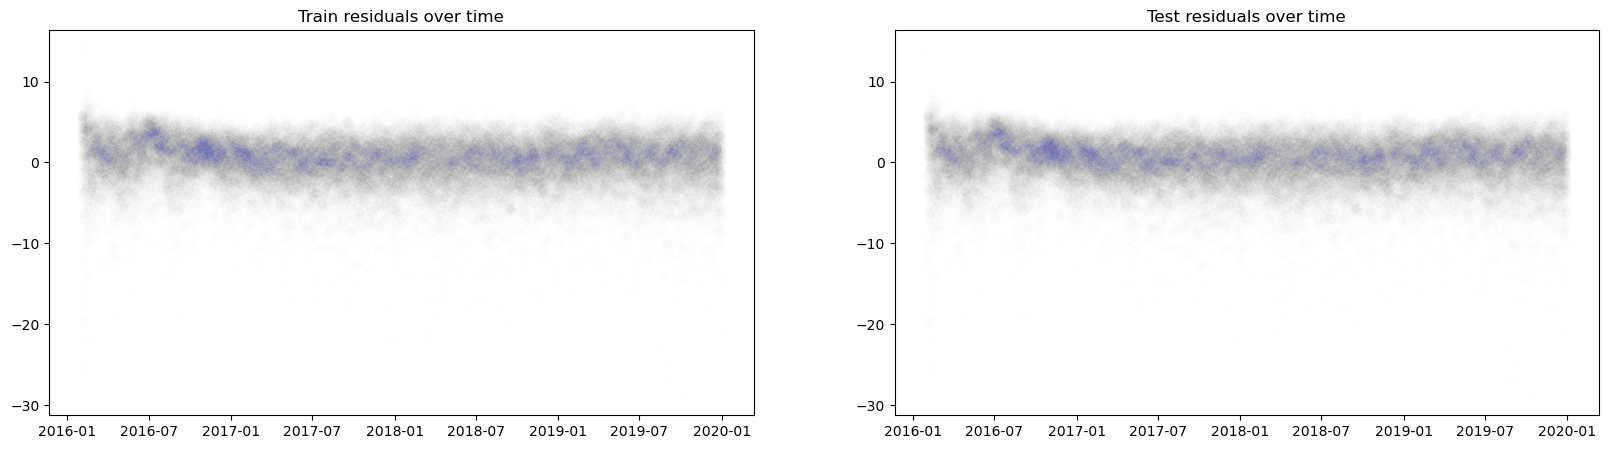

In [100]:
analyze_model(model1_results, line=False)

### Bigrams

In [15]:
X = bigram_features
y = scores[scores.index.isin(X.index)]
print(f"Average post score: {y.mean()}")

Average post score: 7.685962504584925


In [16]:
model2_results = linear_model(X, y)

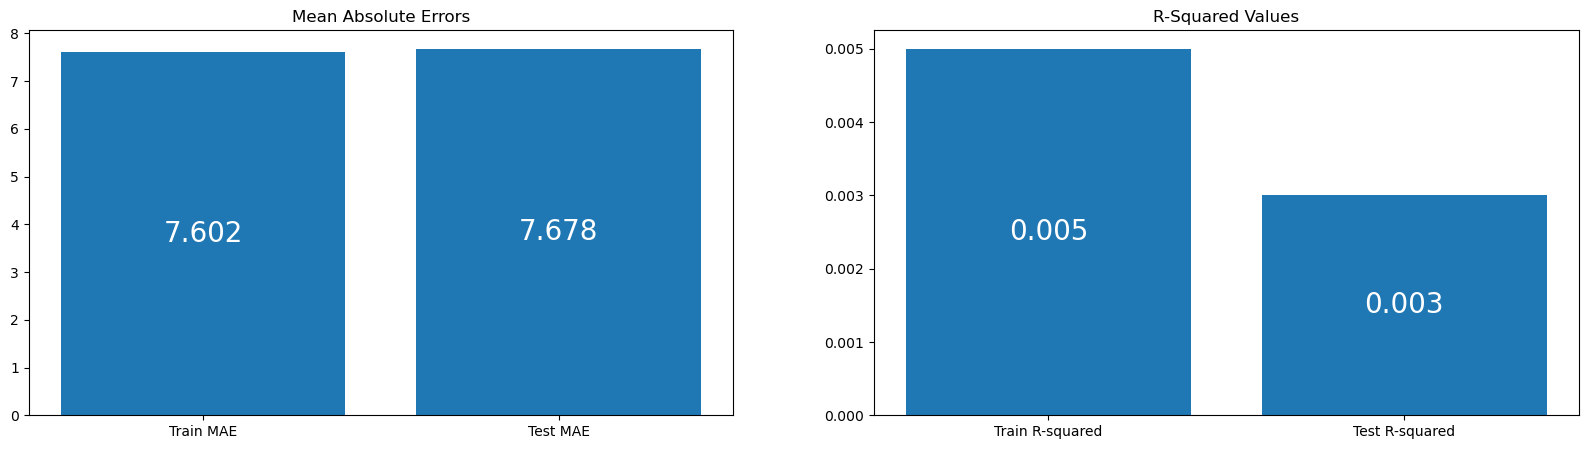

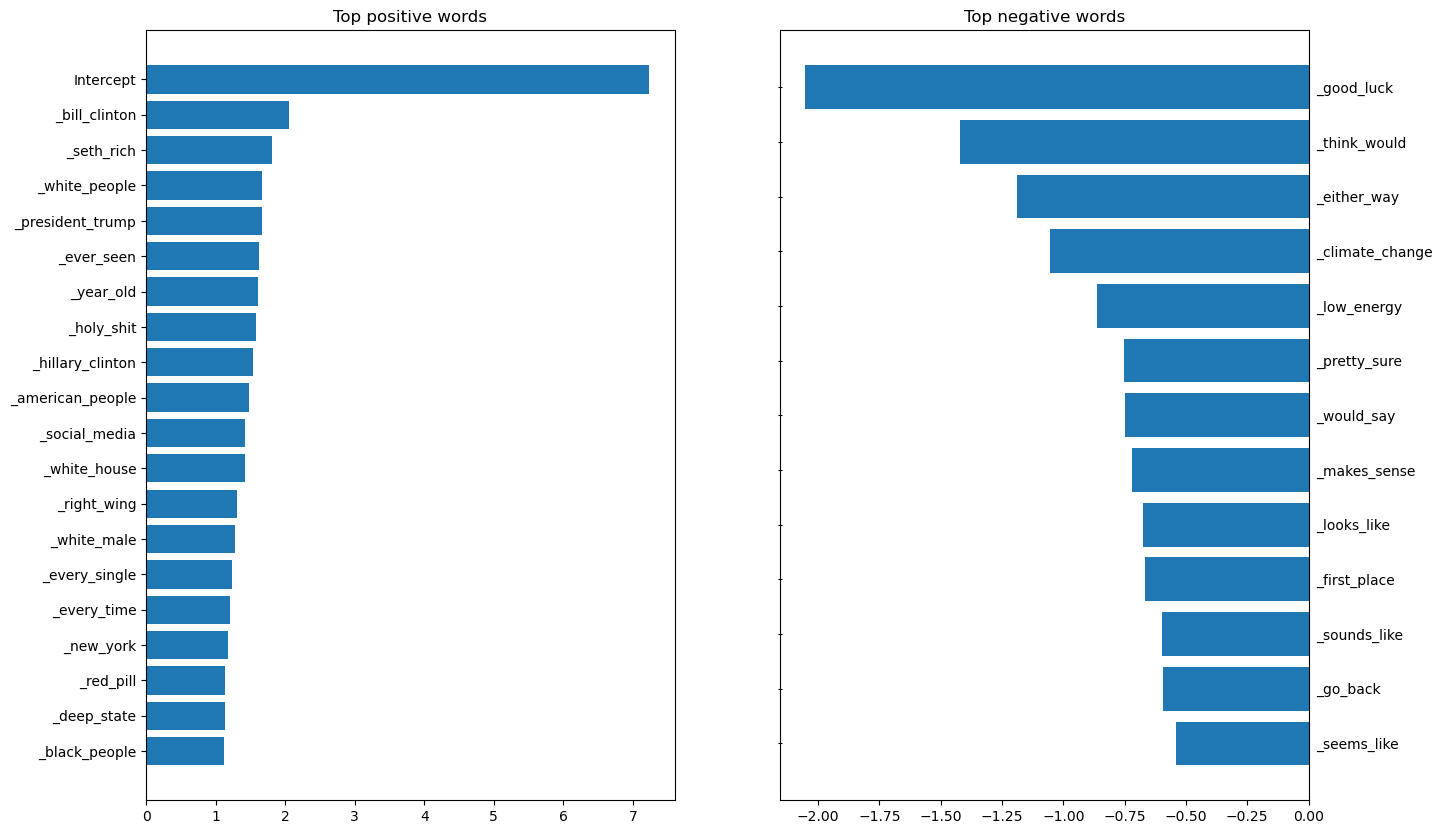

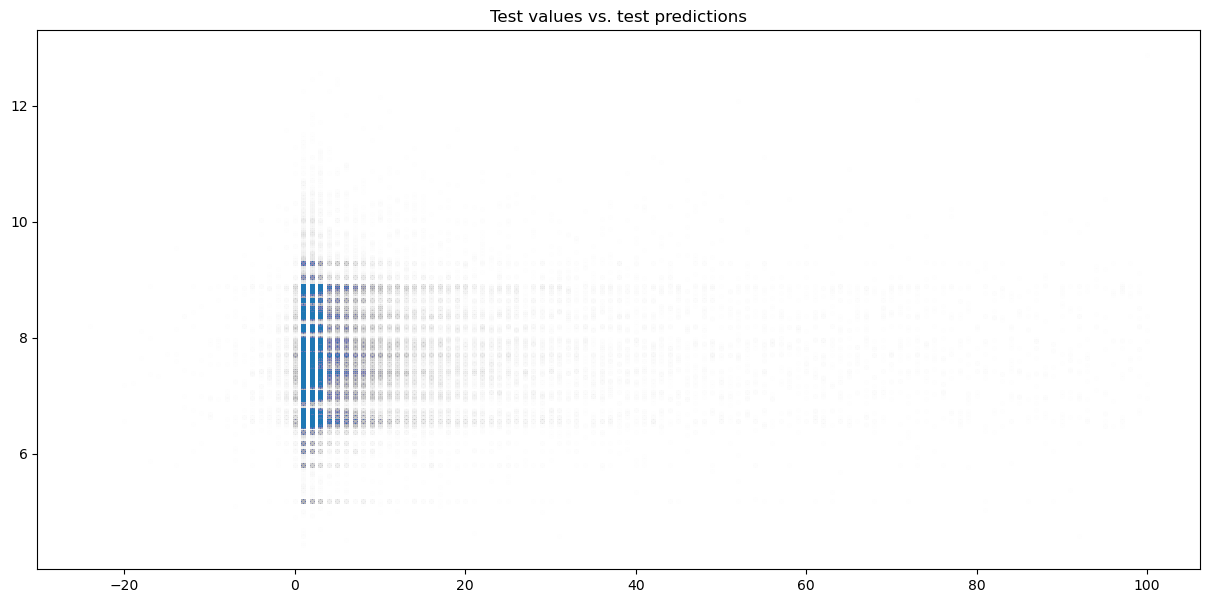

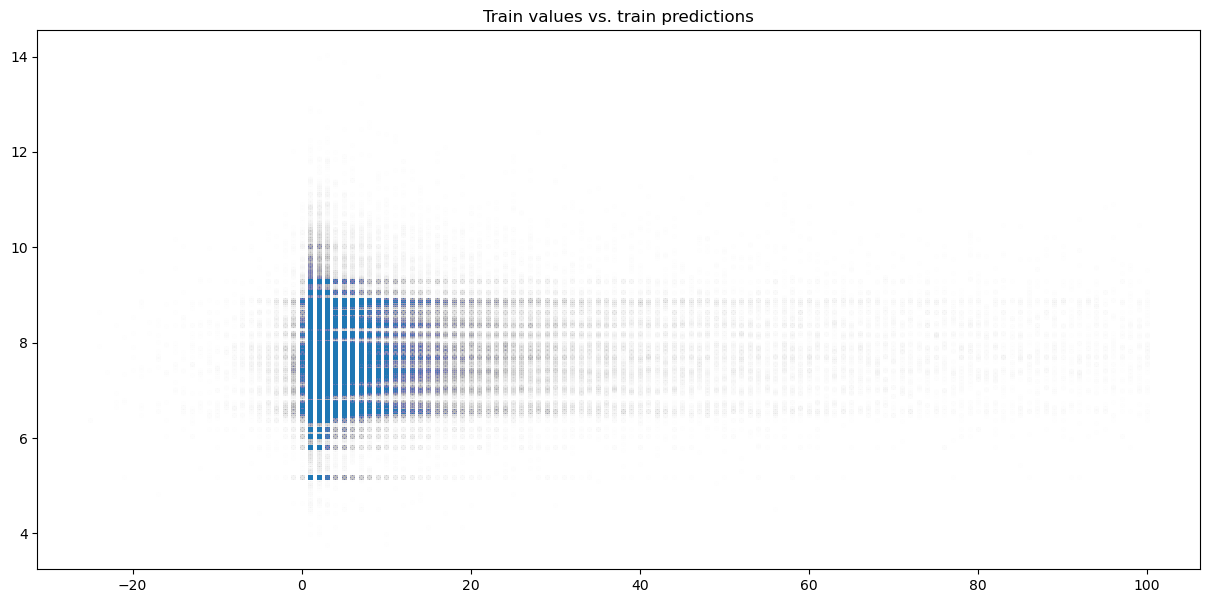

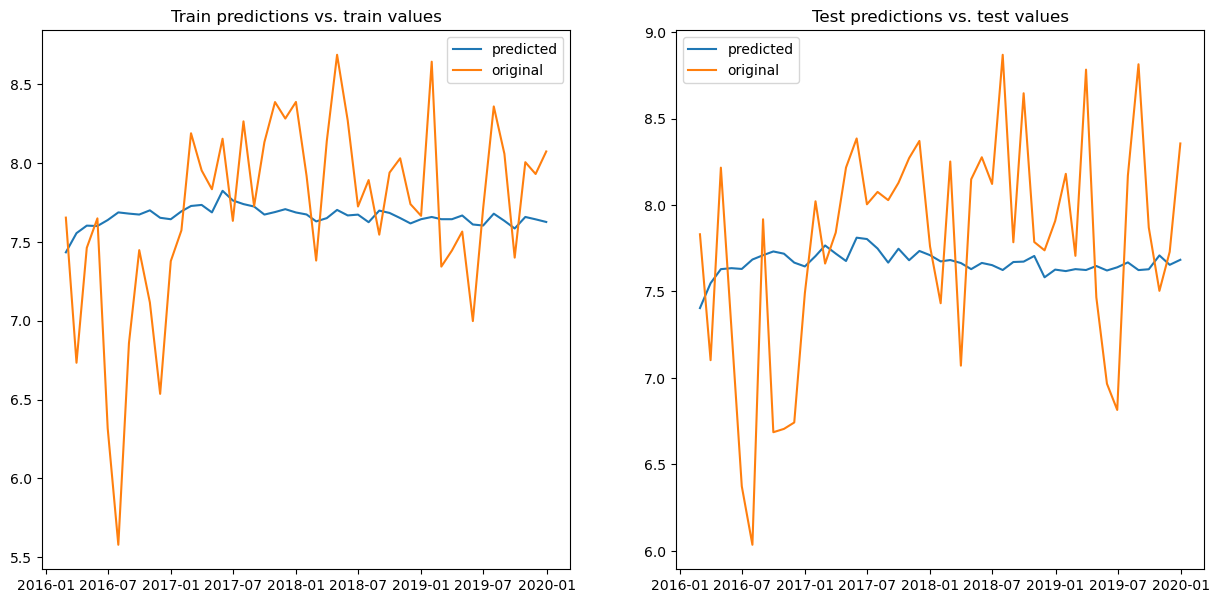

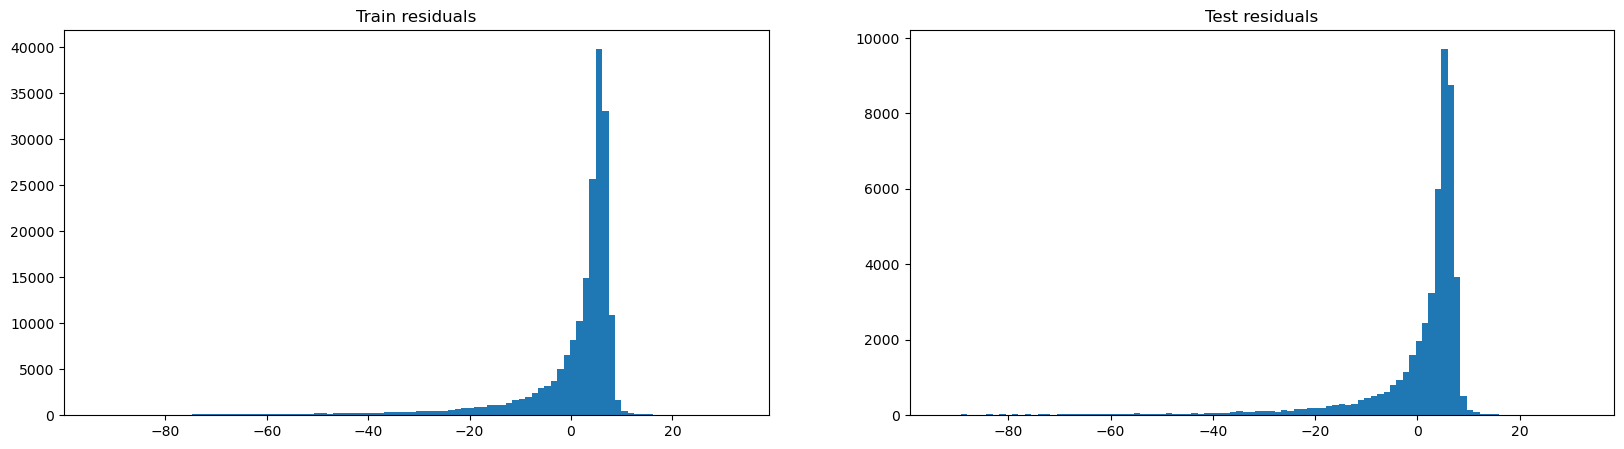

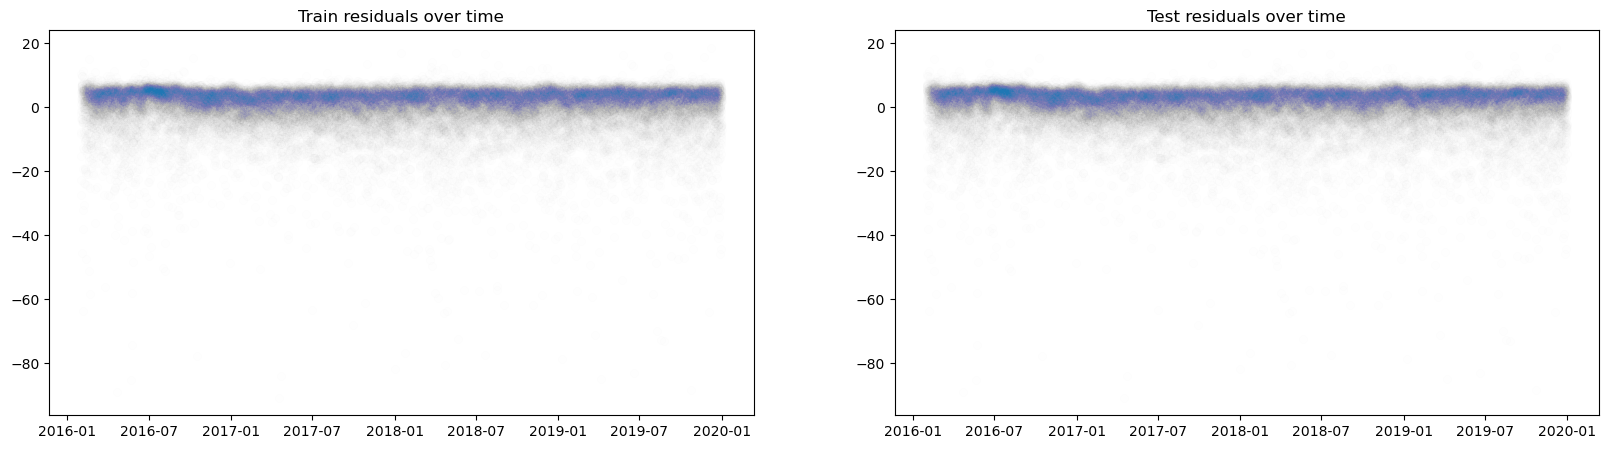

In [101]:
analyze_model(model2_results, line=False)

### Trigrams

In [18]:
X = trigram_features
y = scores[scores.index.isin(X.index)]
print(f"Average post score: {y.mean()}")

Average post score: 8.334464337279815


In [19]:
model3_results = linear_model(X, y)

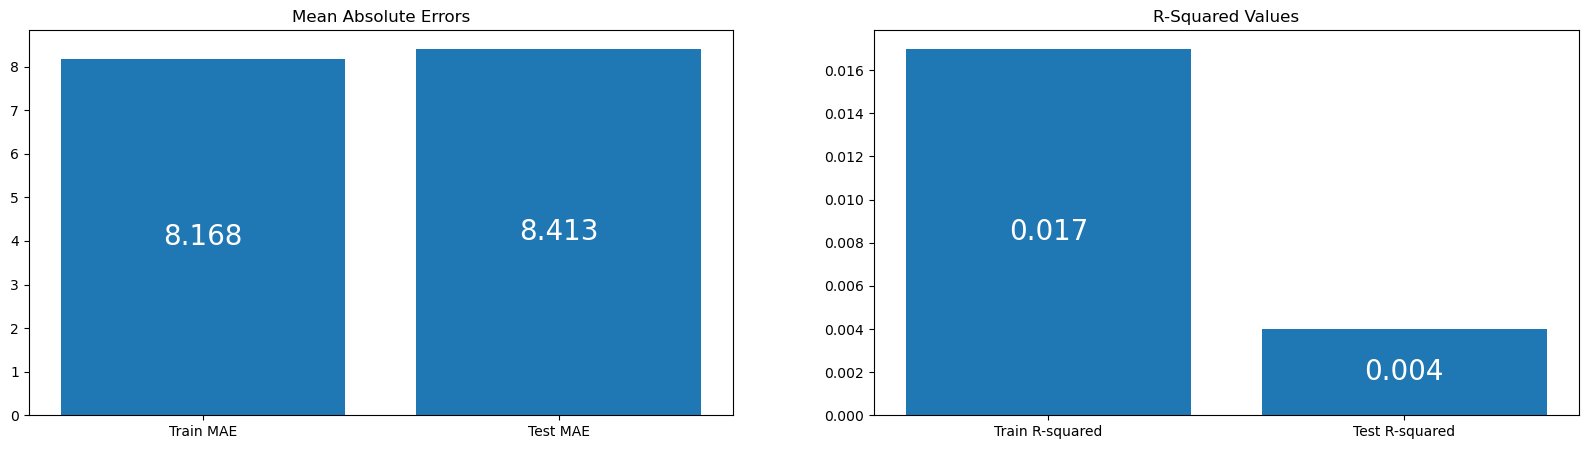

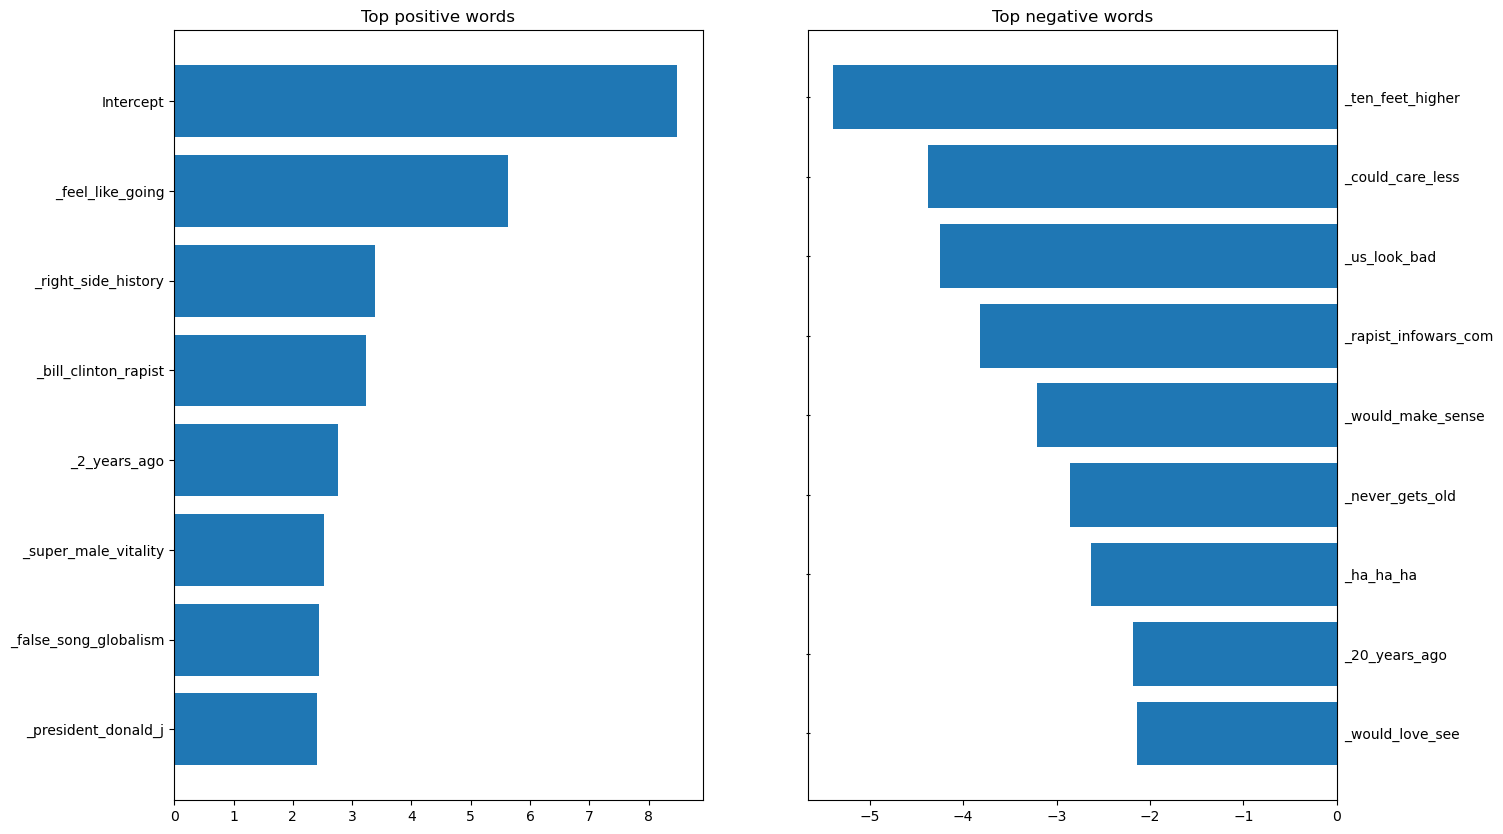

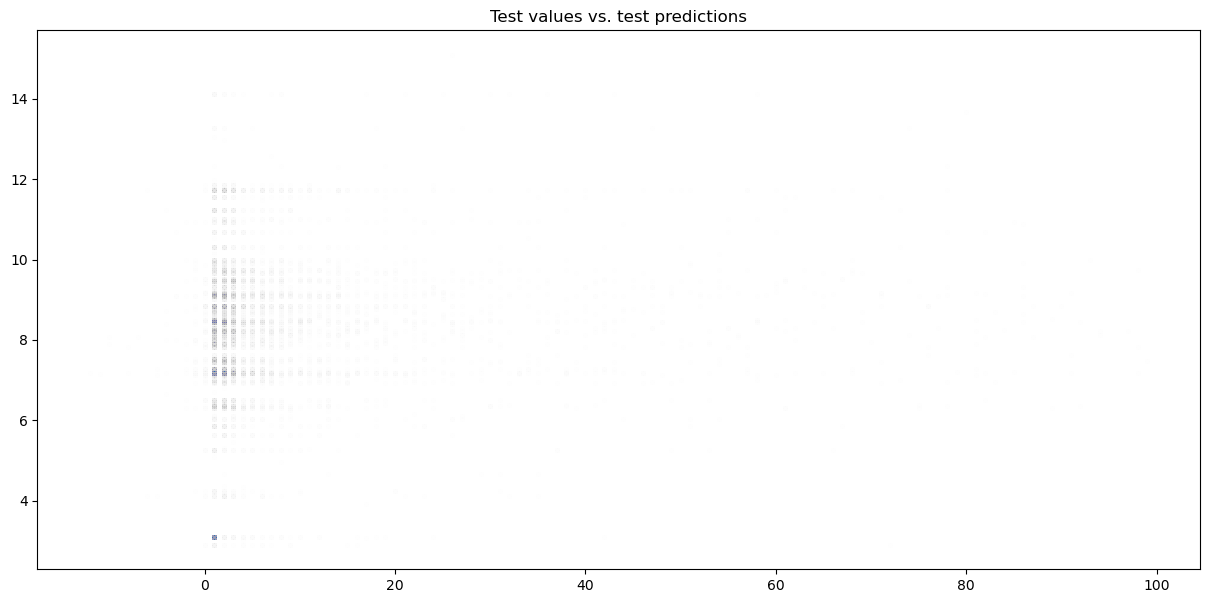

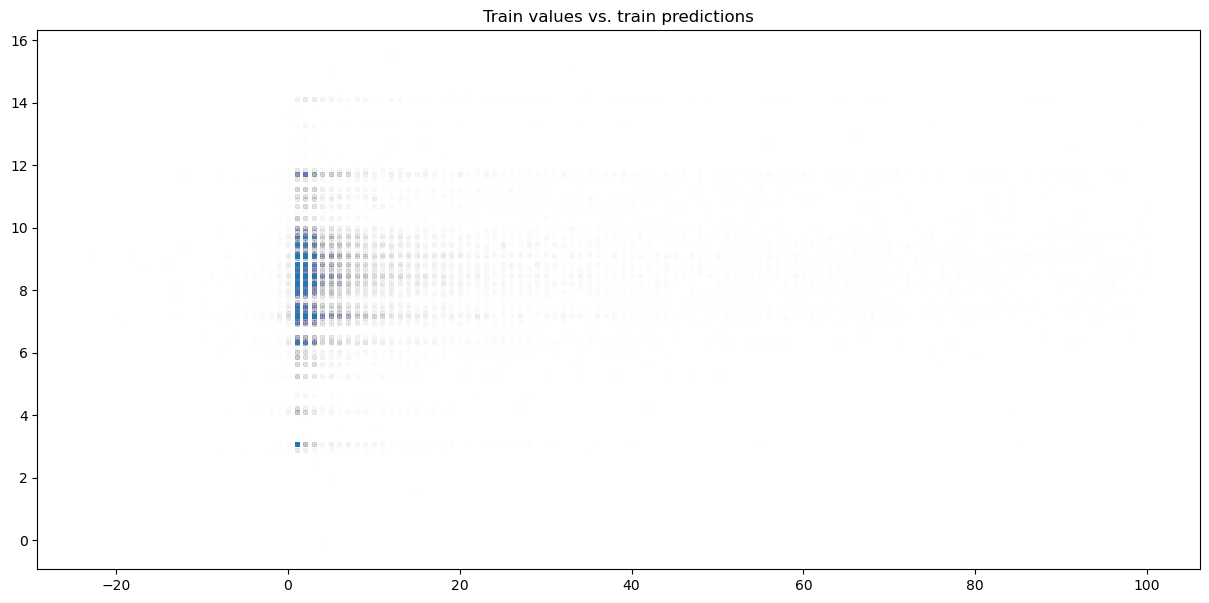

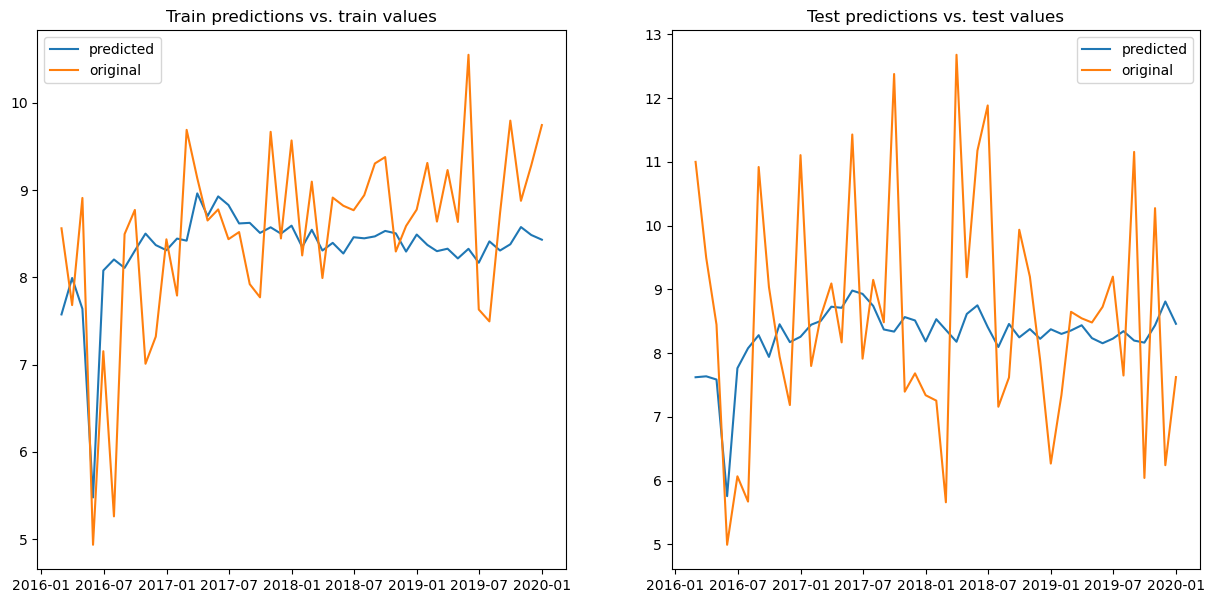

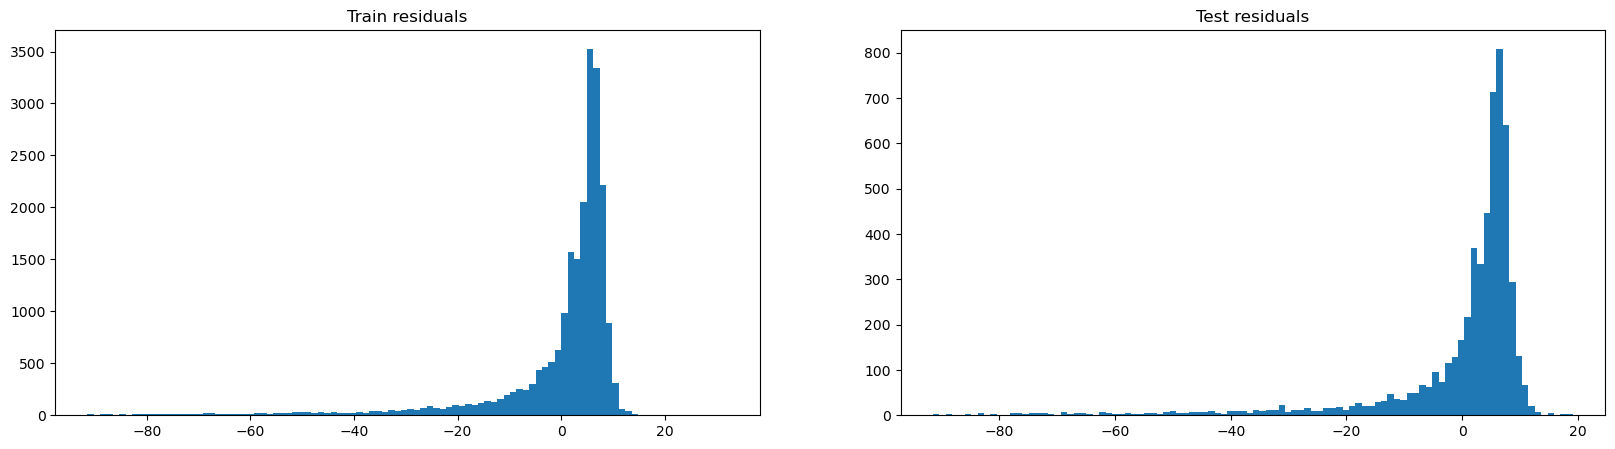

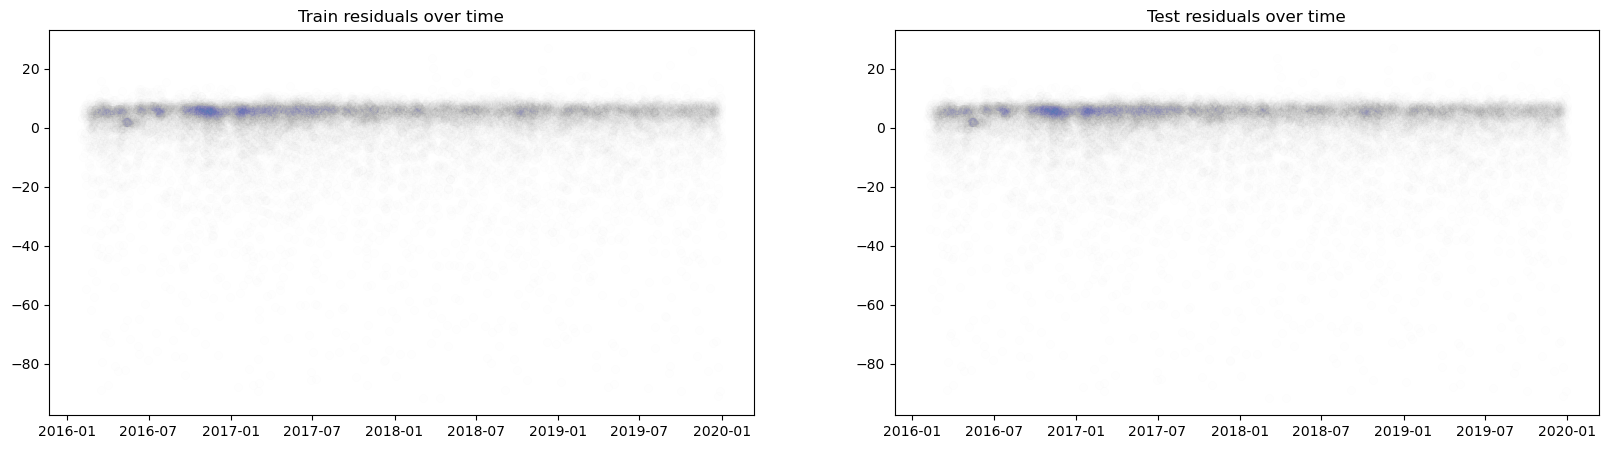

In [102]:
analyze_model(model3_results, line=False)

# Second Model: Linear Regression, VADER as target

### Unigrams

In [74]:
X = unigram_features
y = vader[vader.index.isin(X.index)]

In [75]:
model4_results = linear_model(X, y)

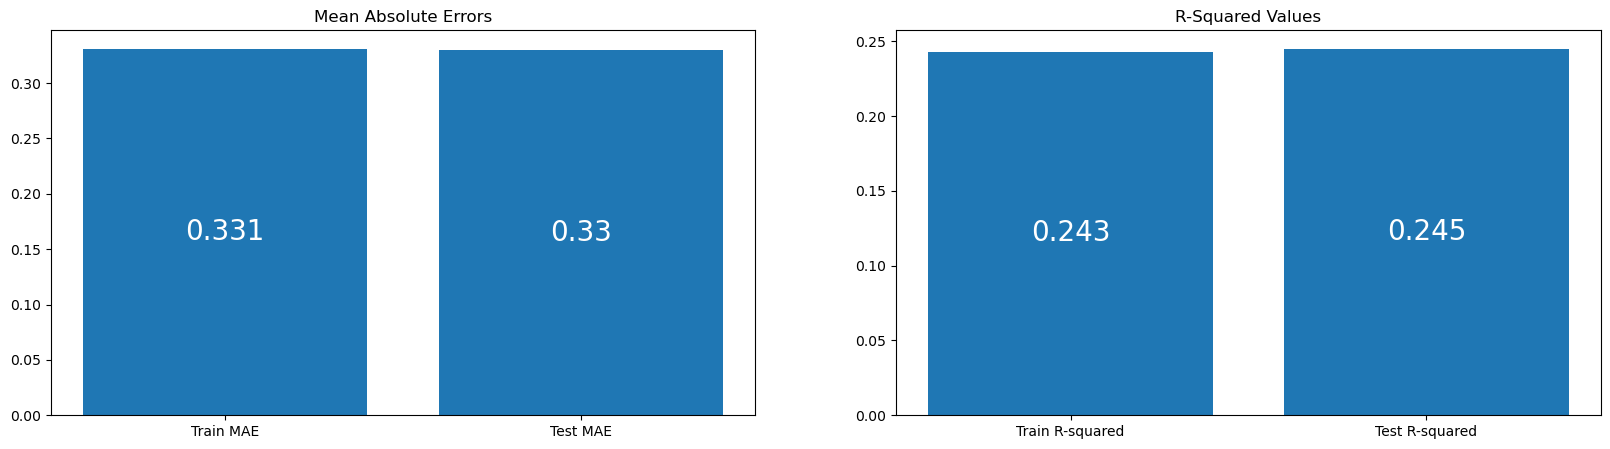

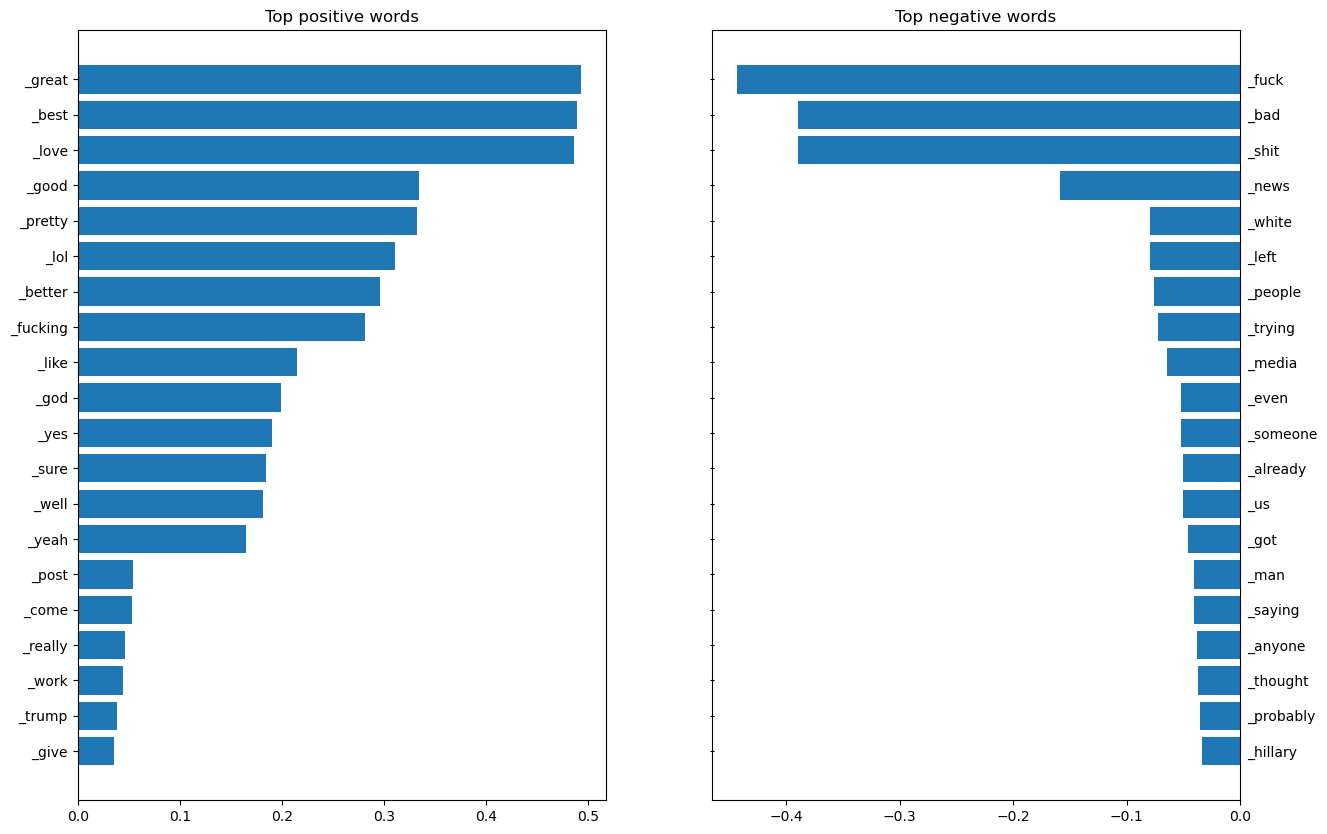

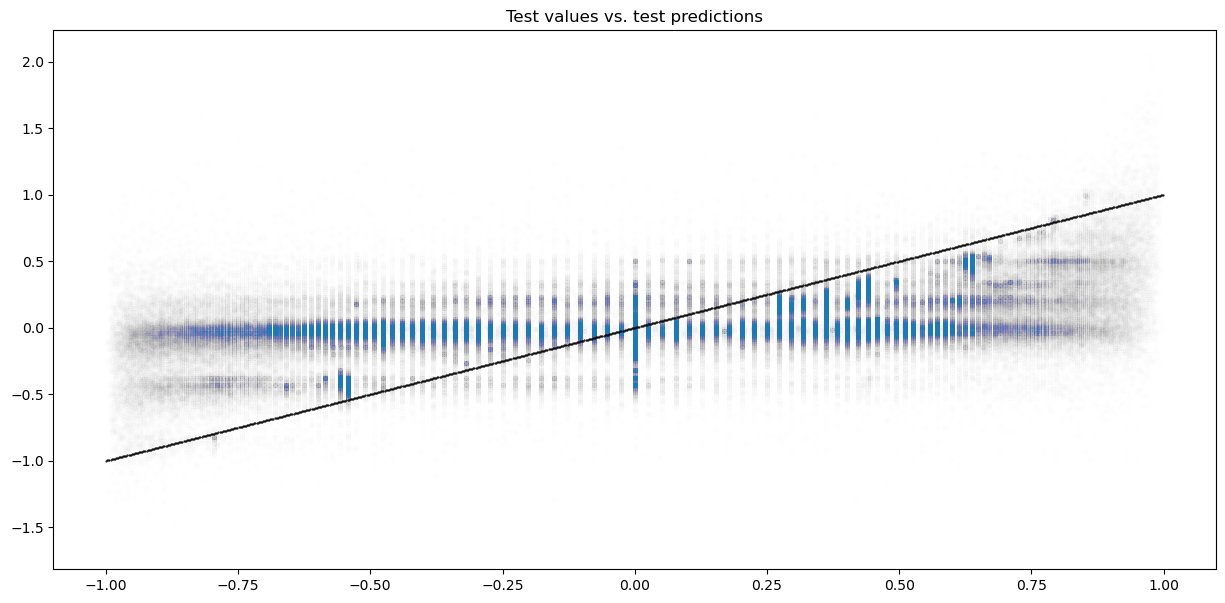

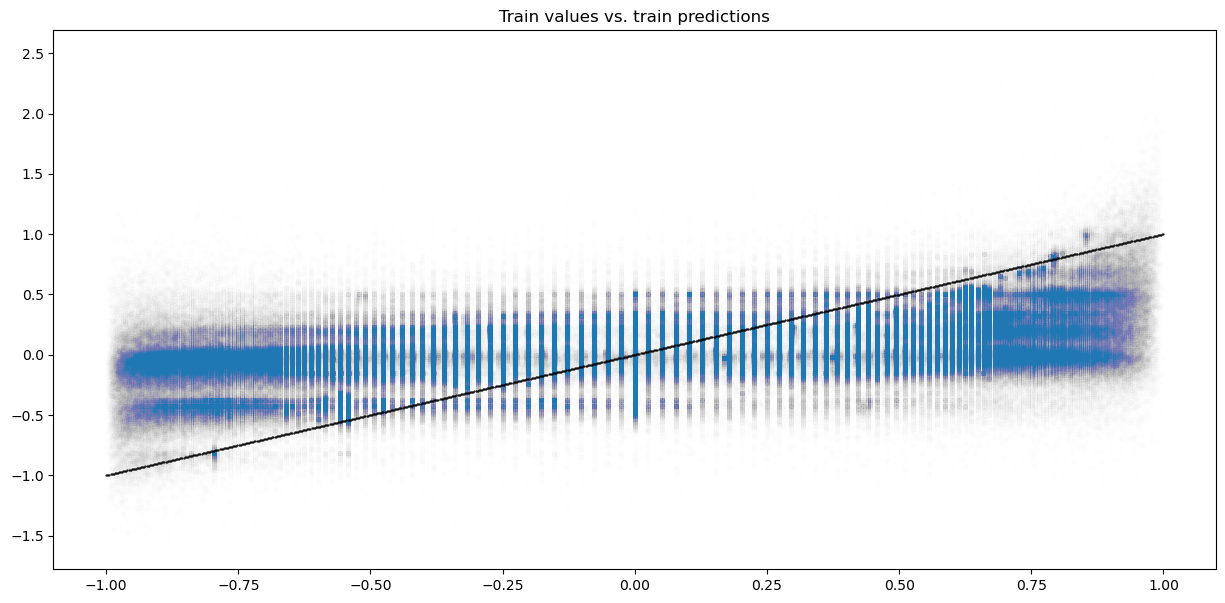

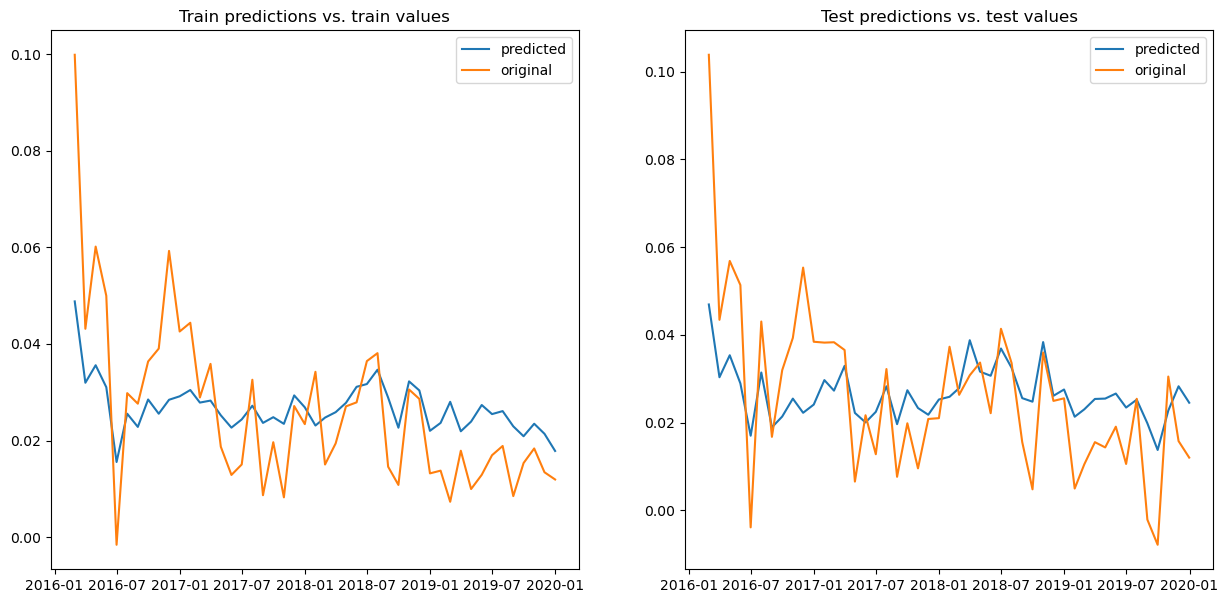

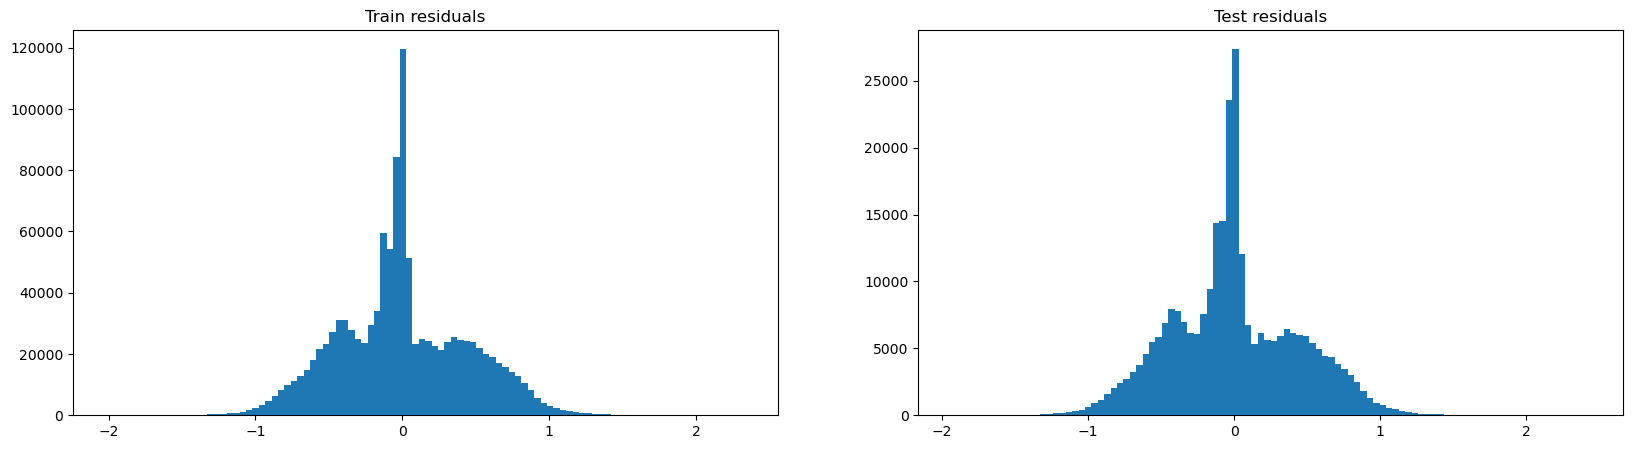

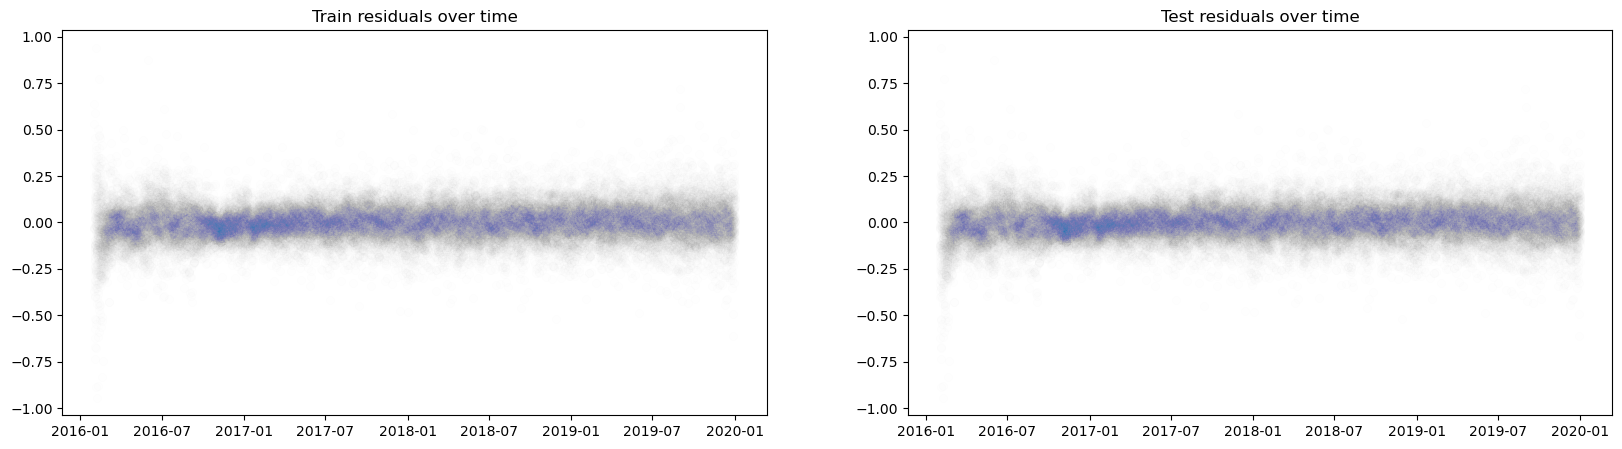

In [103]:
analyze_model(model4_results)

### Bigrams

In [77]:
X = bigram_features
y = vader[vader.index.isin(X.index)]

In [78]:
model5_results = linear_model(X, y)

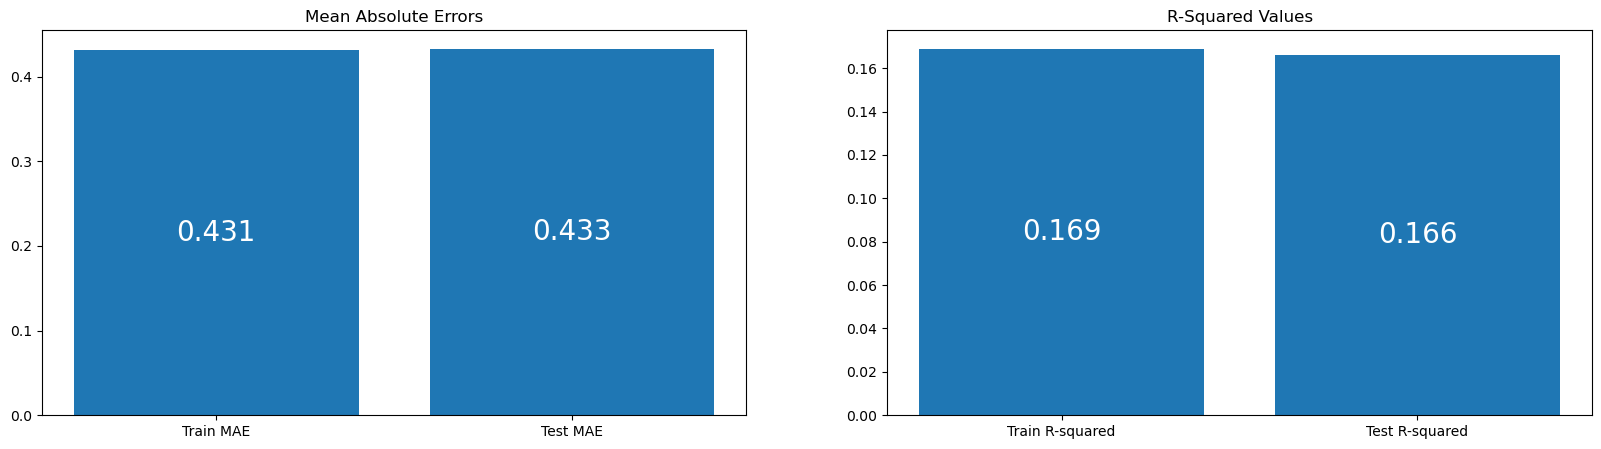

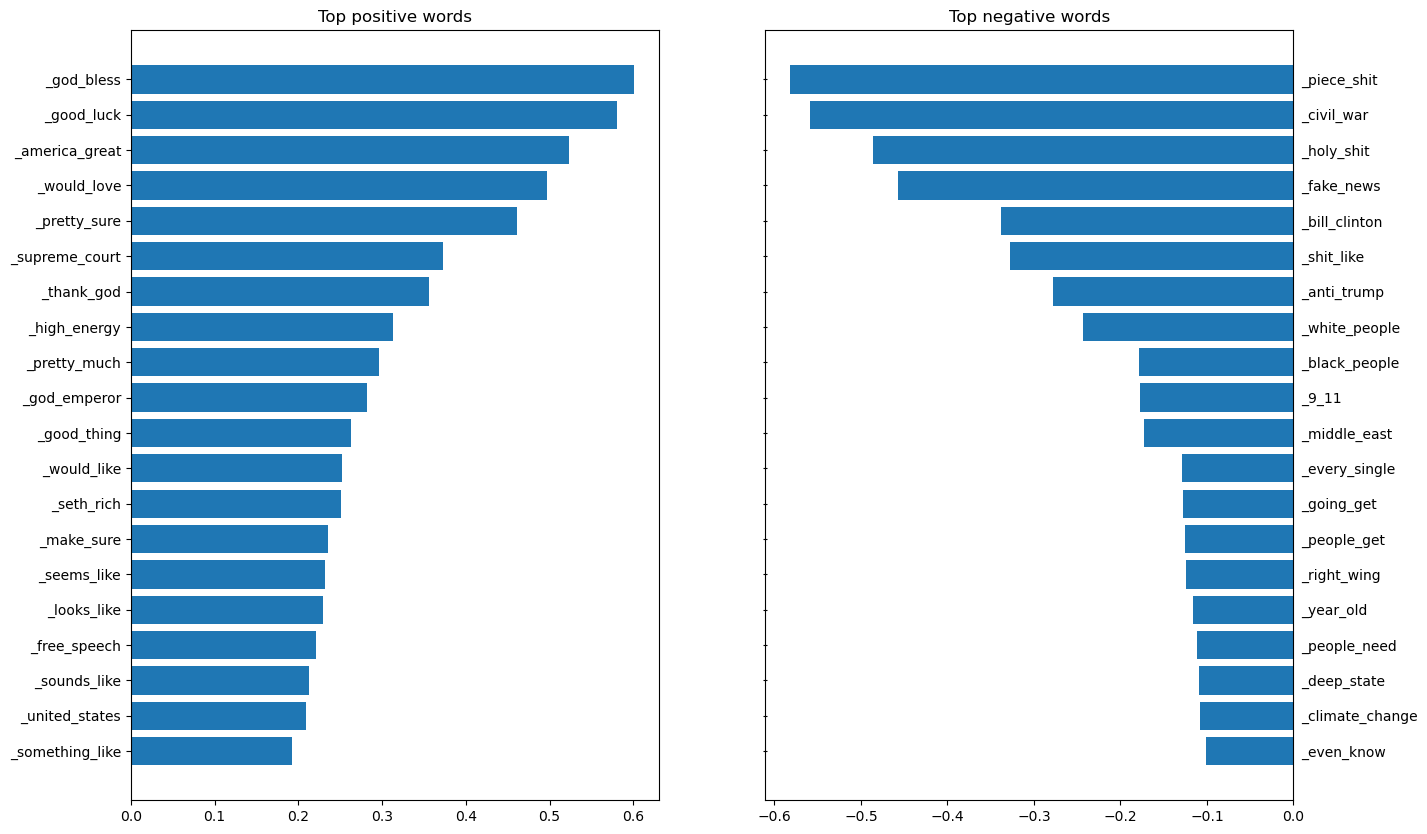

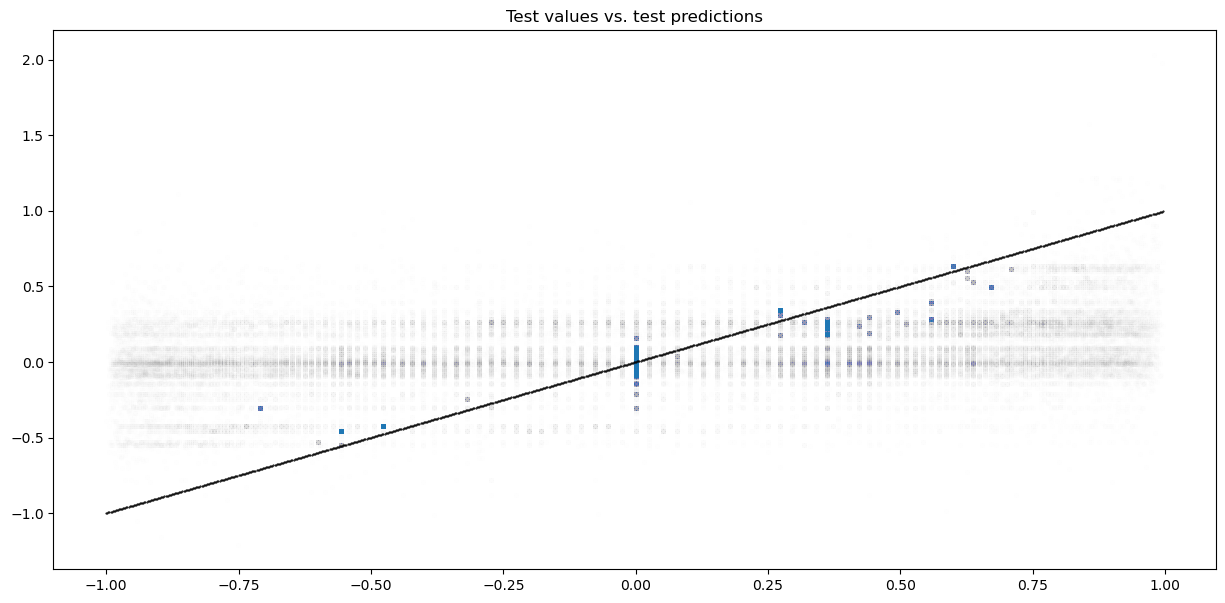

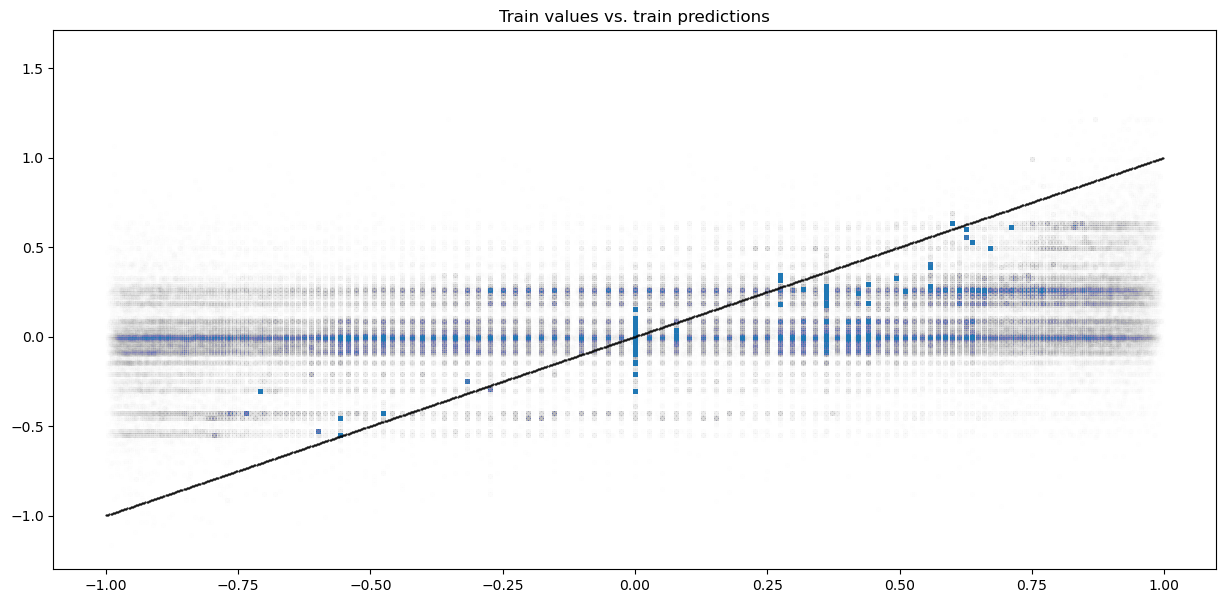

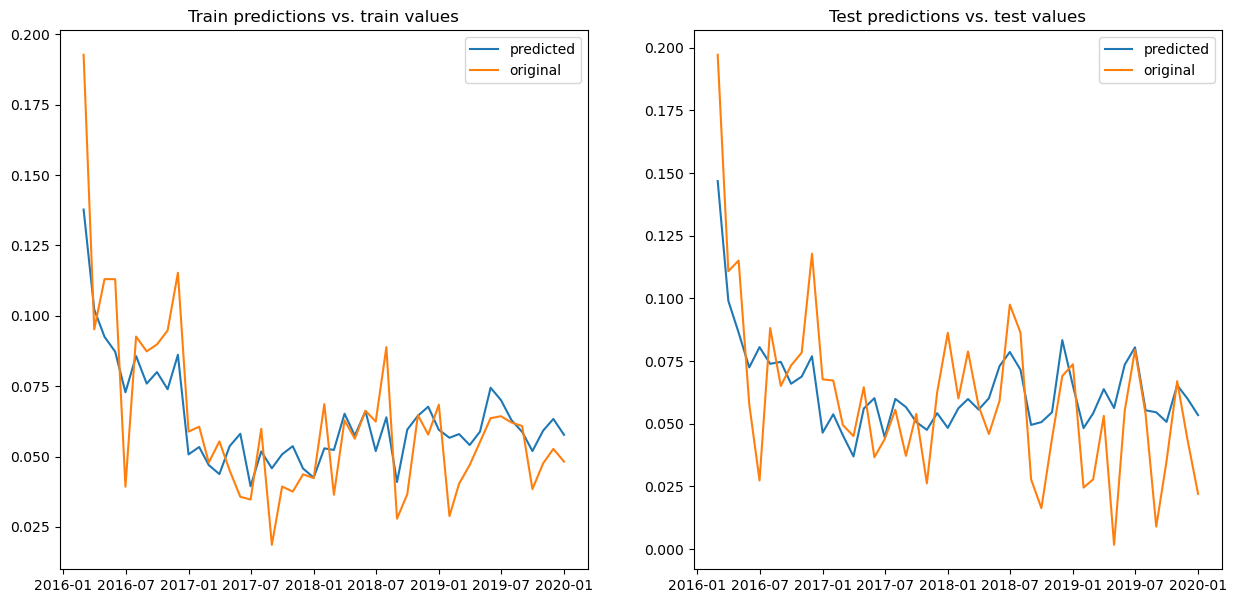

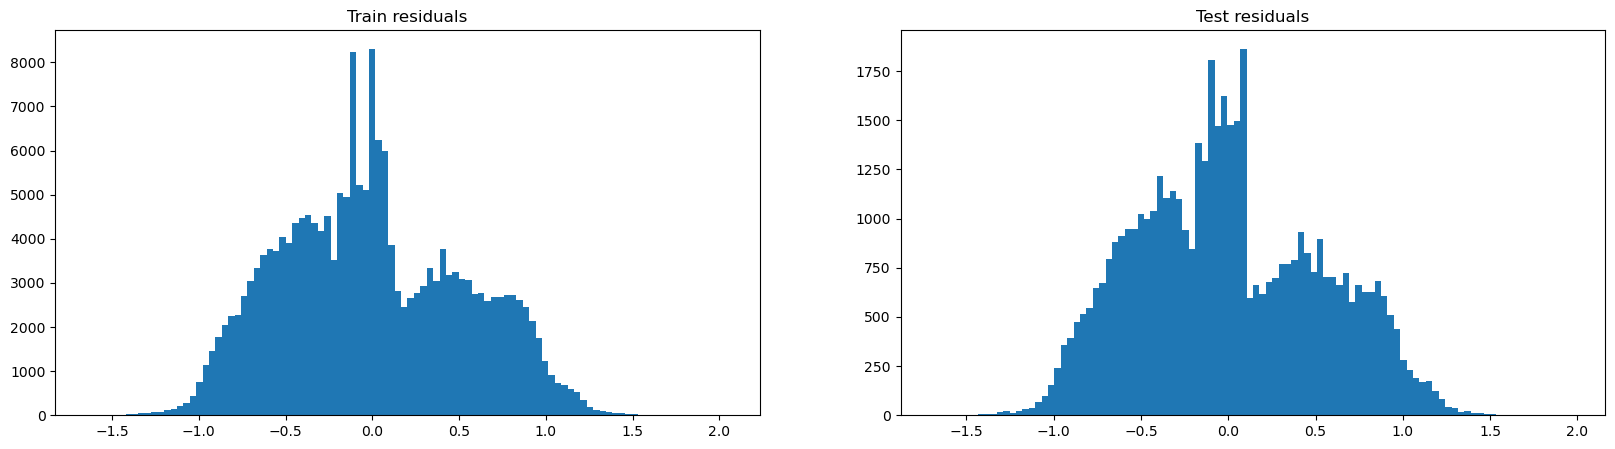

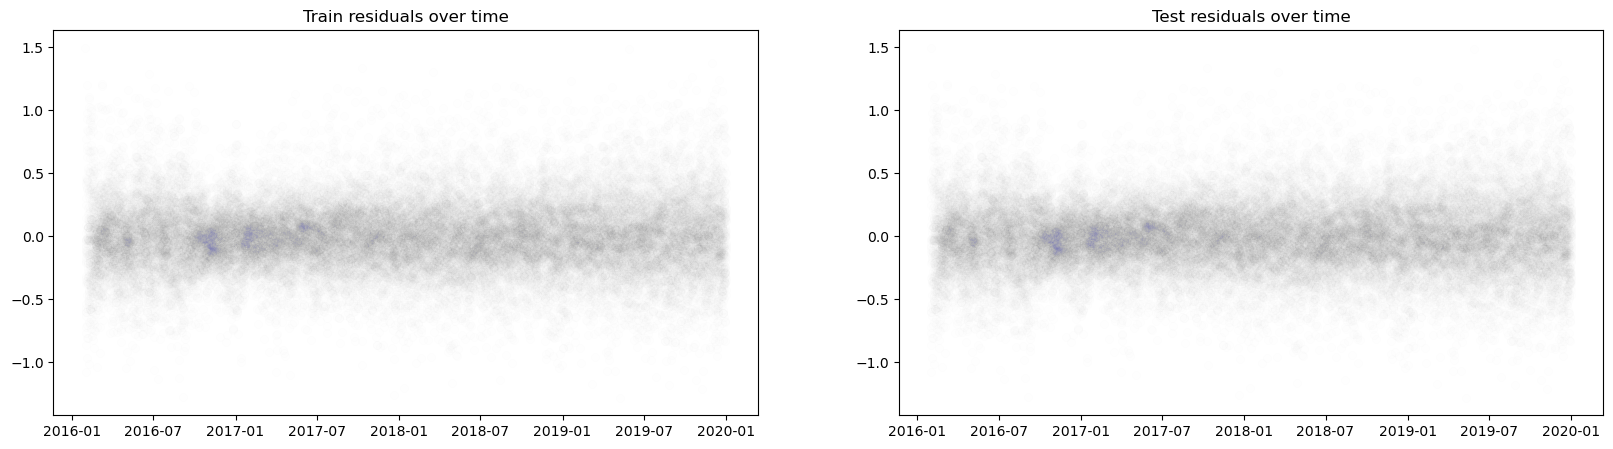

In [104]:
analyze_model(model5_results)

### Trigrams

In [80]:
X = trigram_features
y = vader[vader.index.isin(X.index)]

In [81]:
model6_results = linear_model(X, y)

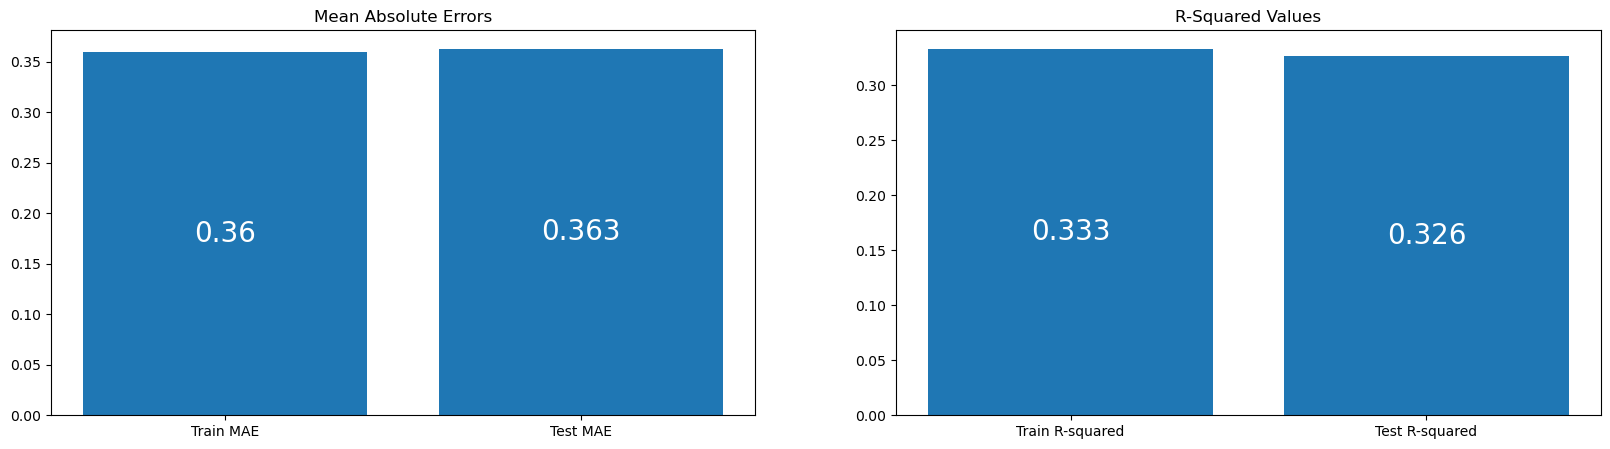

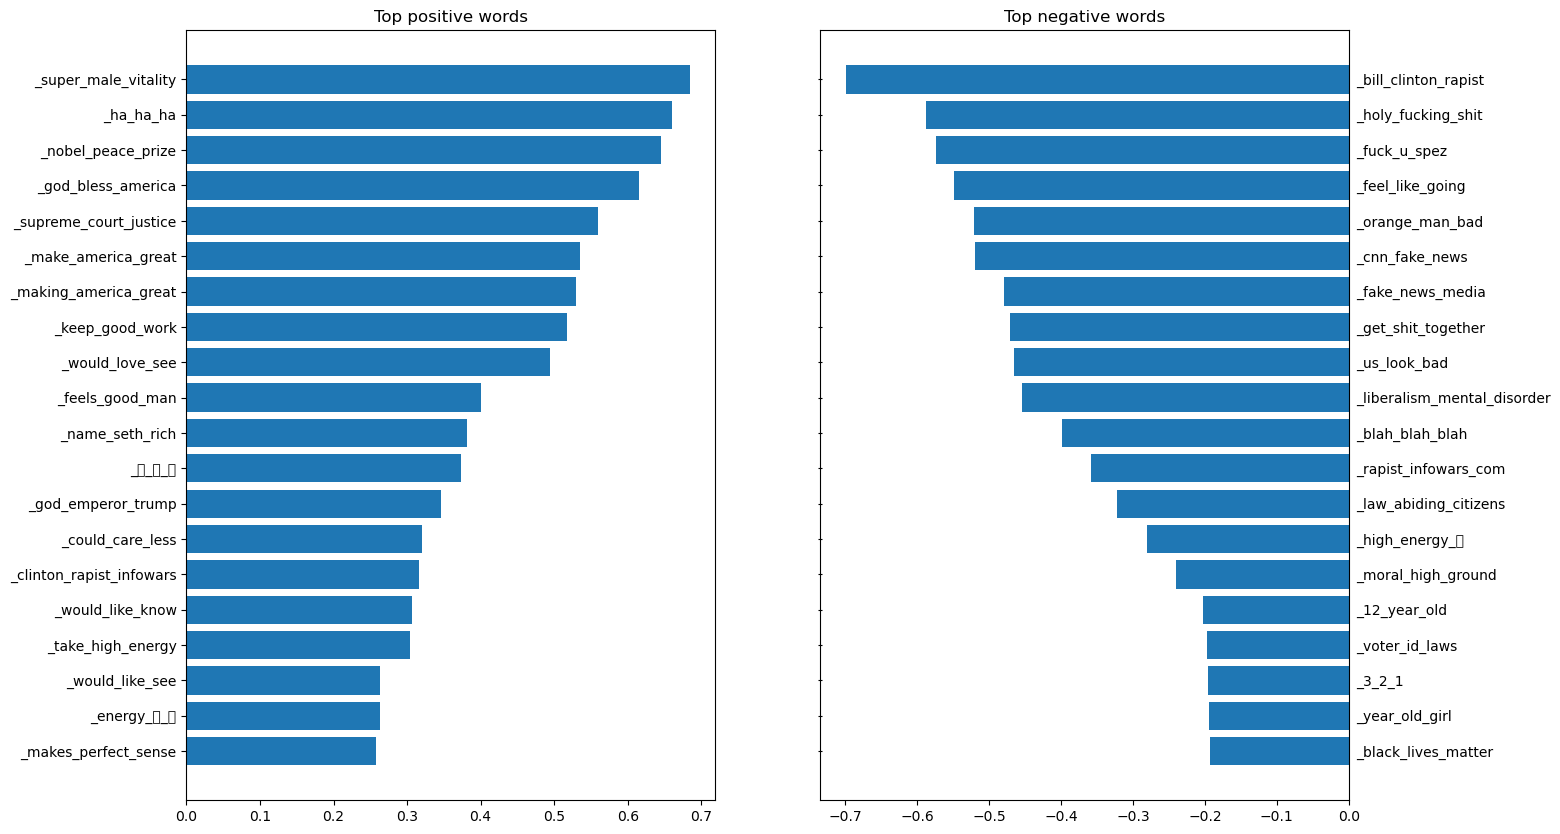

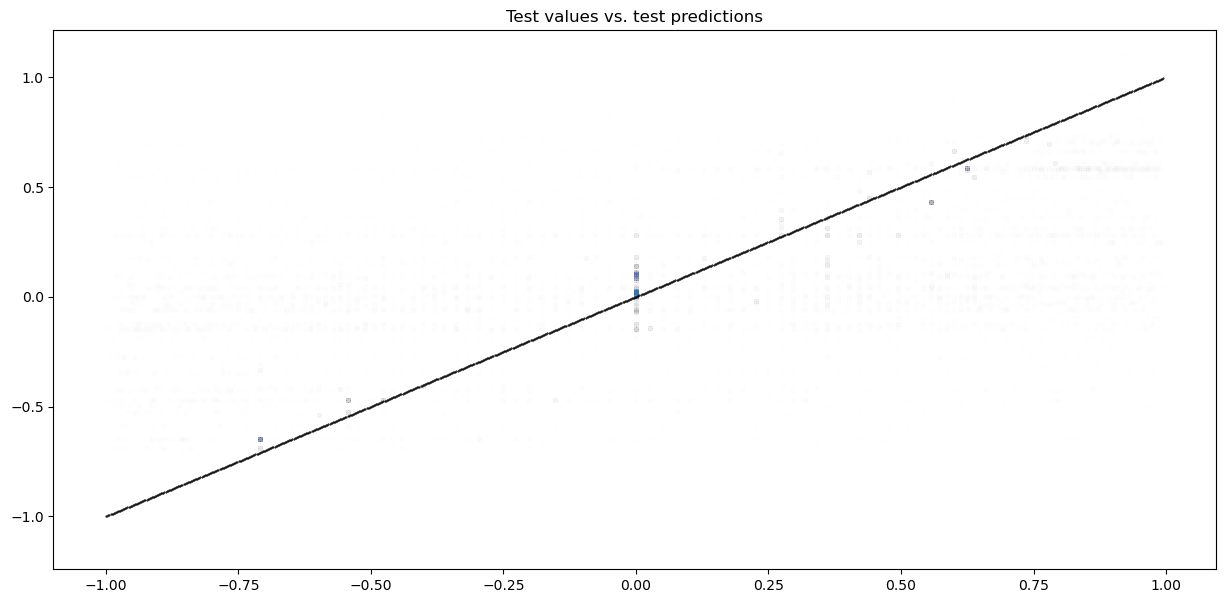

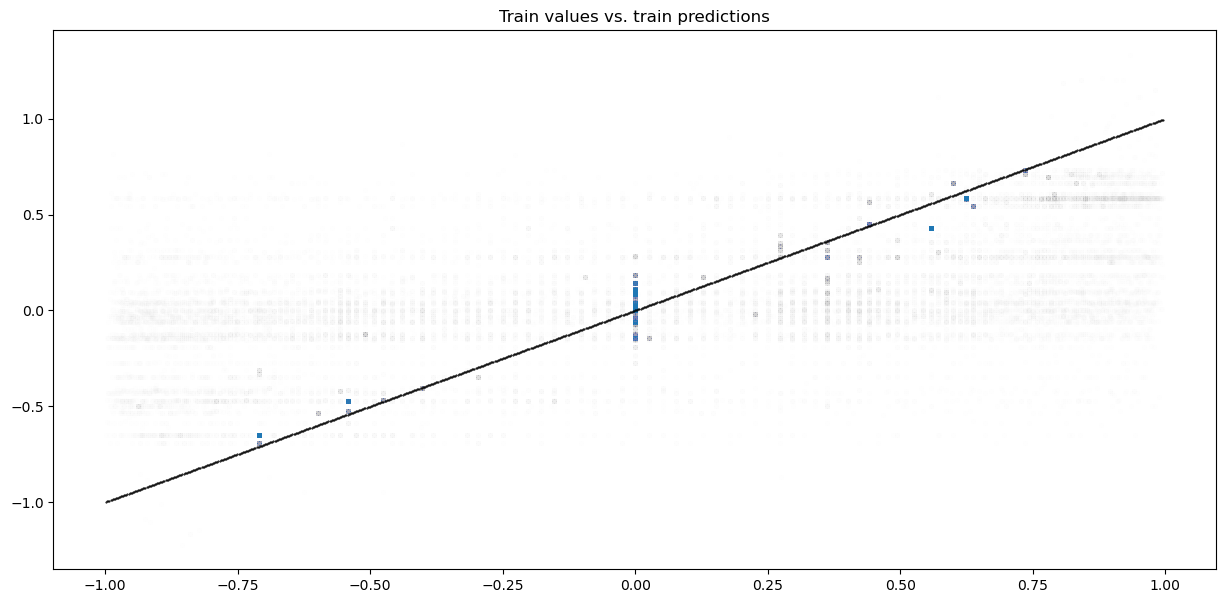

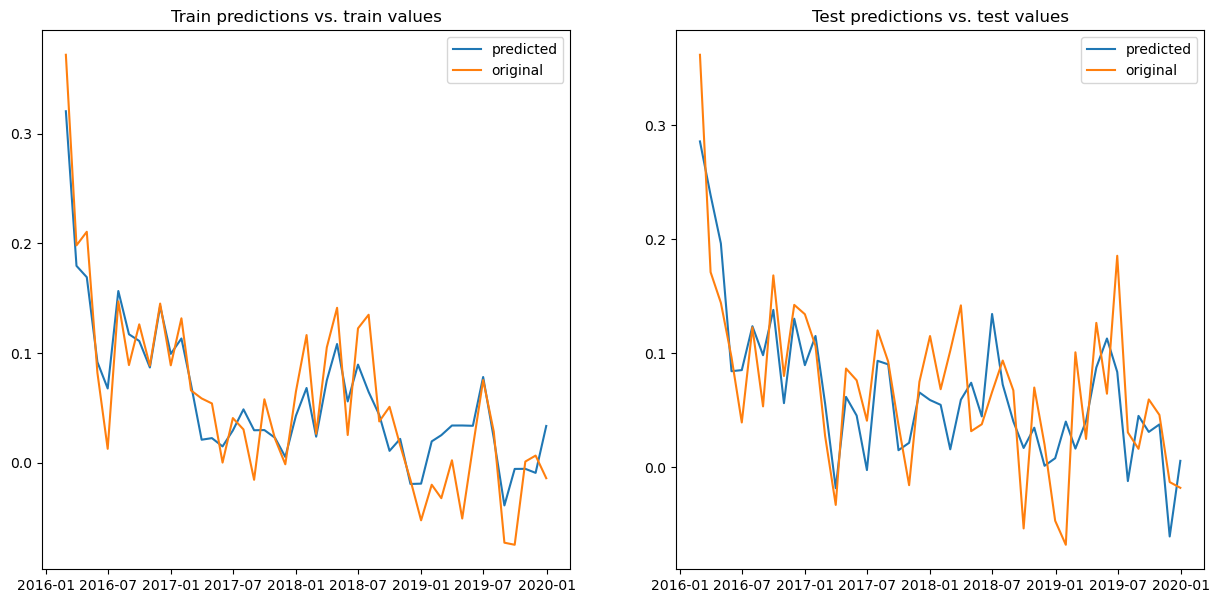

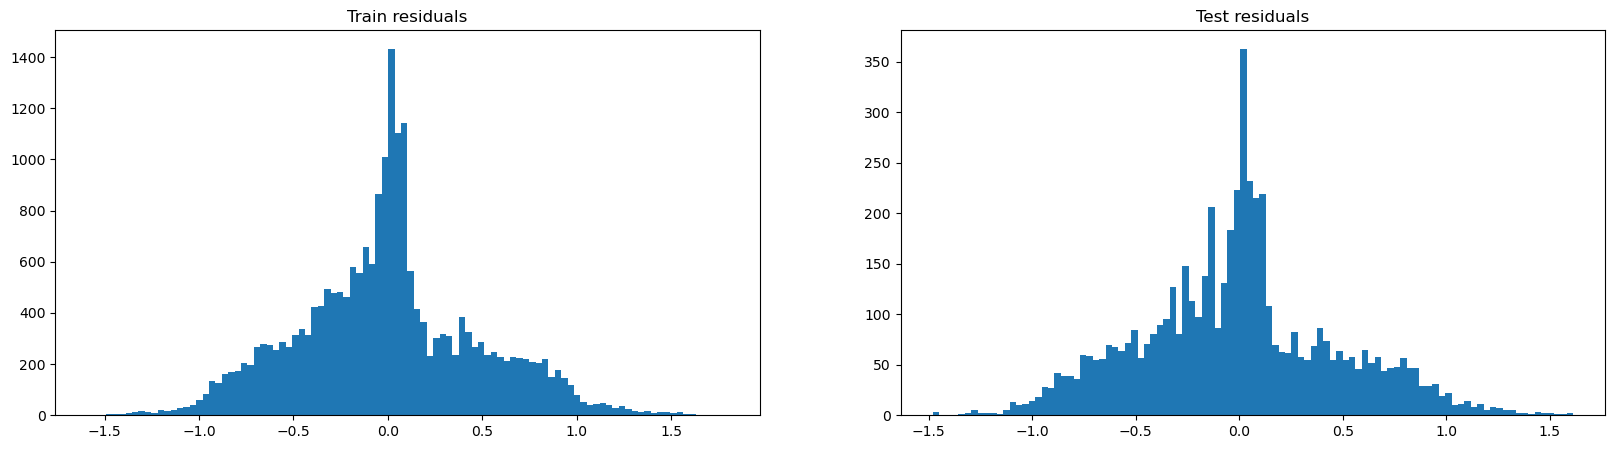

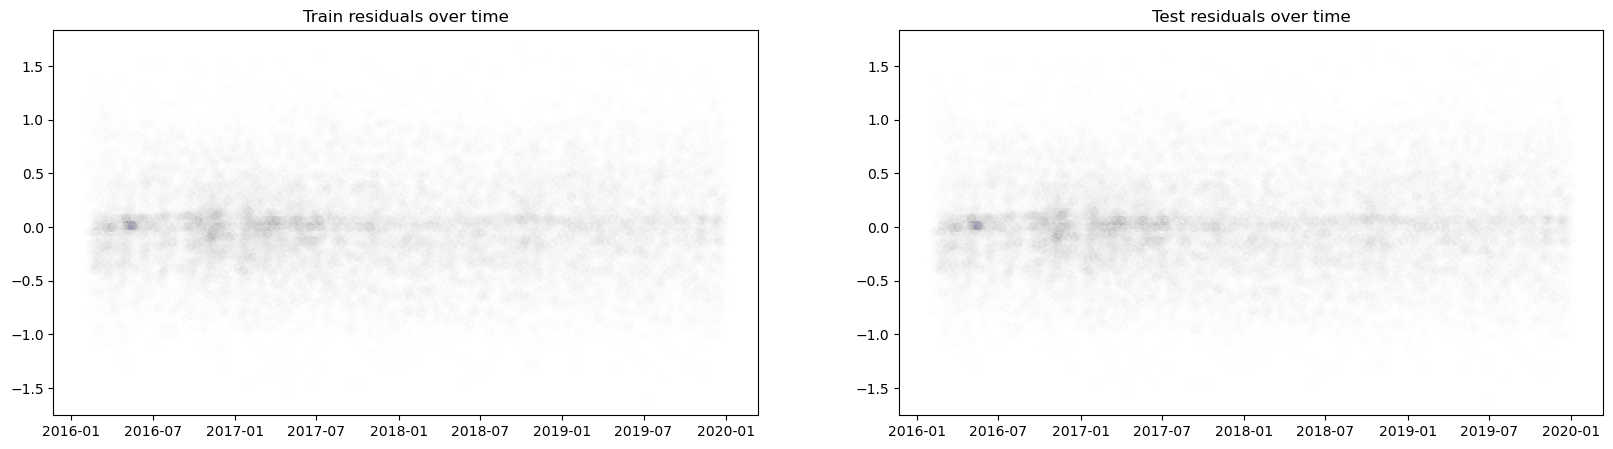

In [105]:
analyze_model(model6_results)

# Third Model: Linear Regression, VADER as target, scores removed

The distribution of sentiment is saturated with neutral posts. If we remove these, does it help model accuracy?

<Axes: >

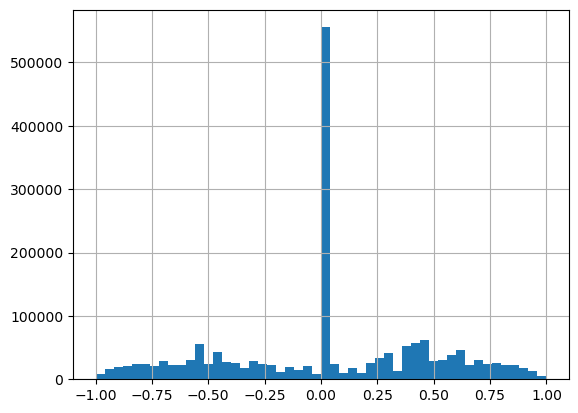

In [70]:
vader.hist(bins=50)

<Axes: >

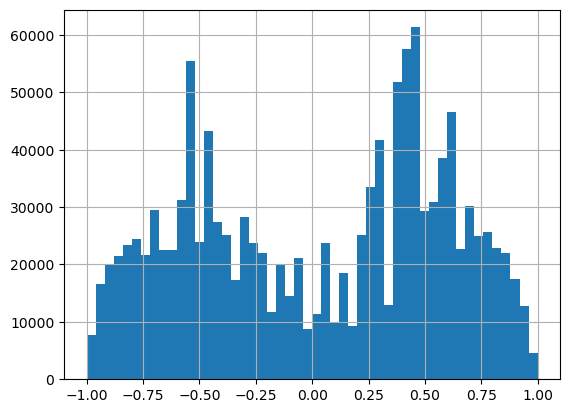

In [71]:
vader[vader!=0].hist(bins=50)

### Unigrams

In [84]:
y = vader[(vader.index.isin(unigram_features.index)) & (vader!=0)]
X = unigram_features[unigram_features.index.isin(y.index)]

In [87]:
model7_results = linear_model(X, y)

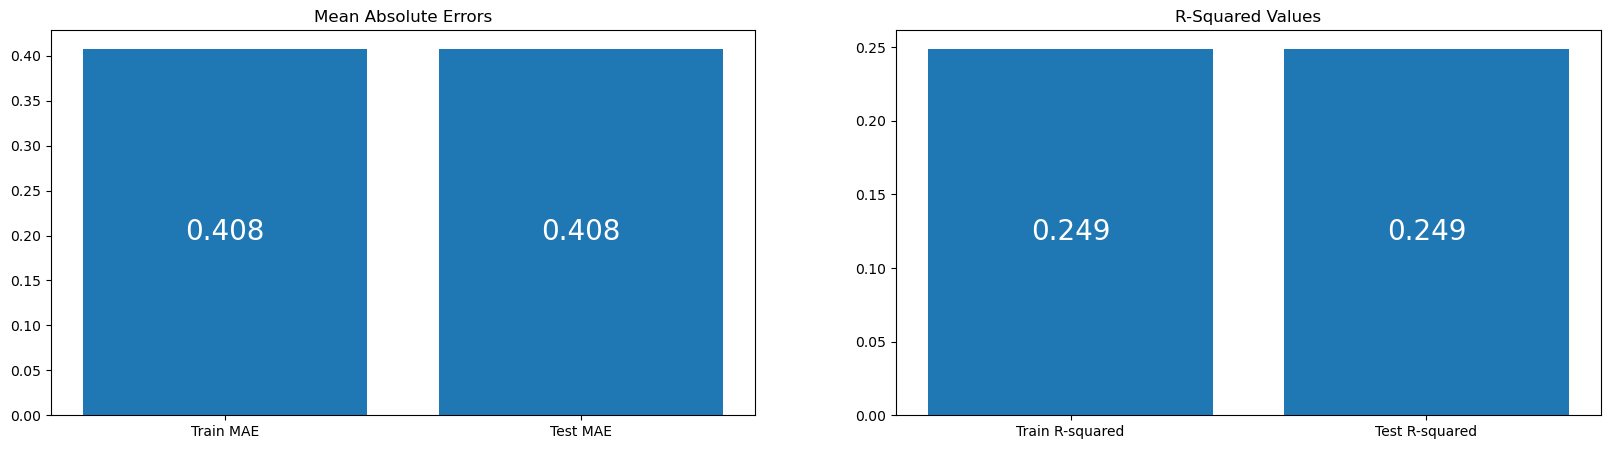

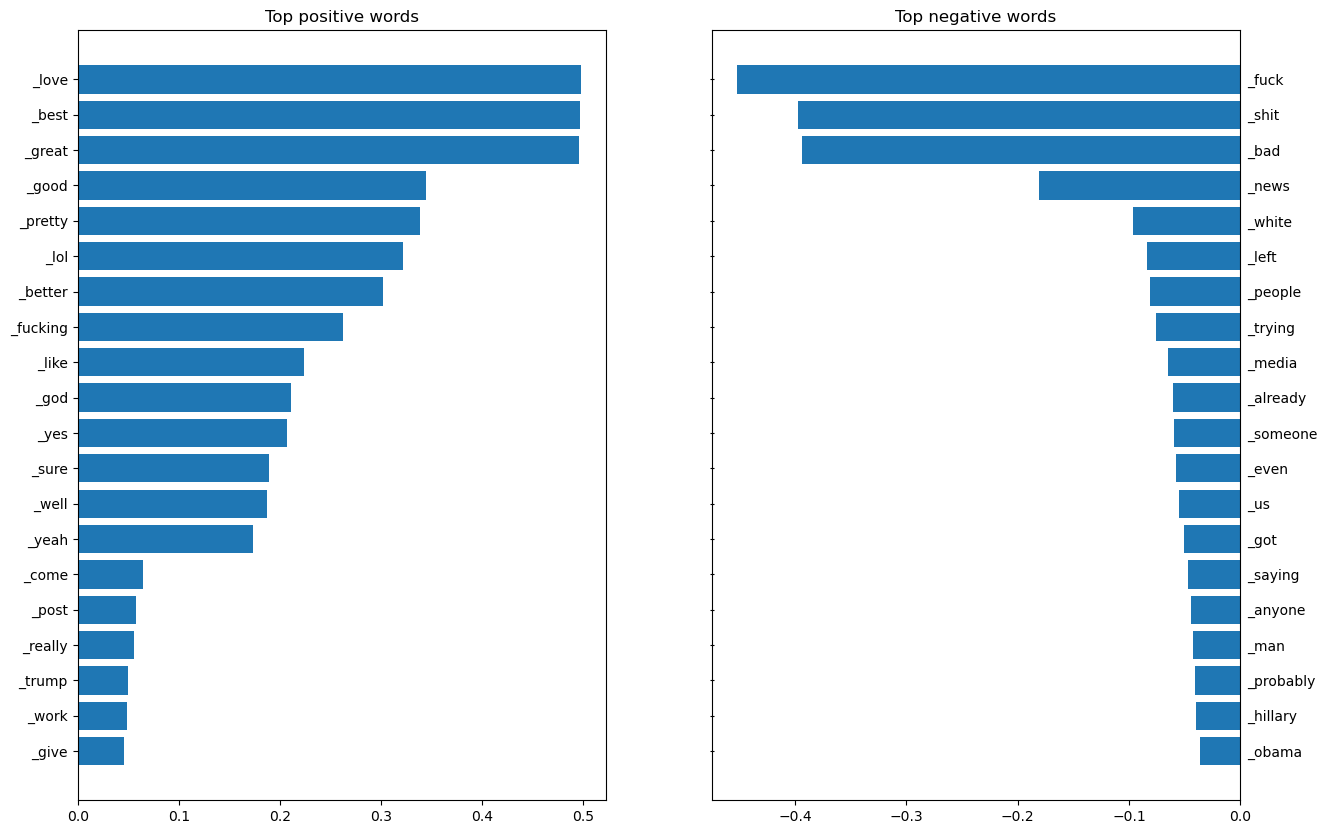

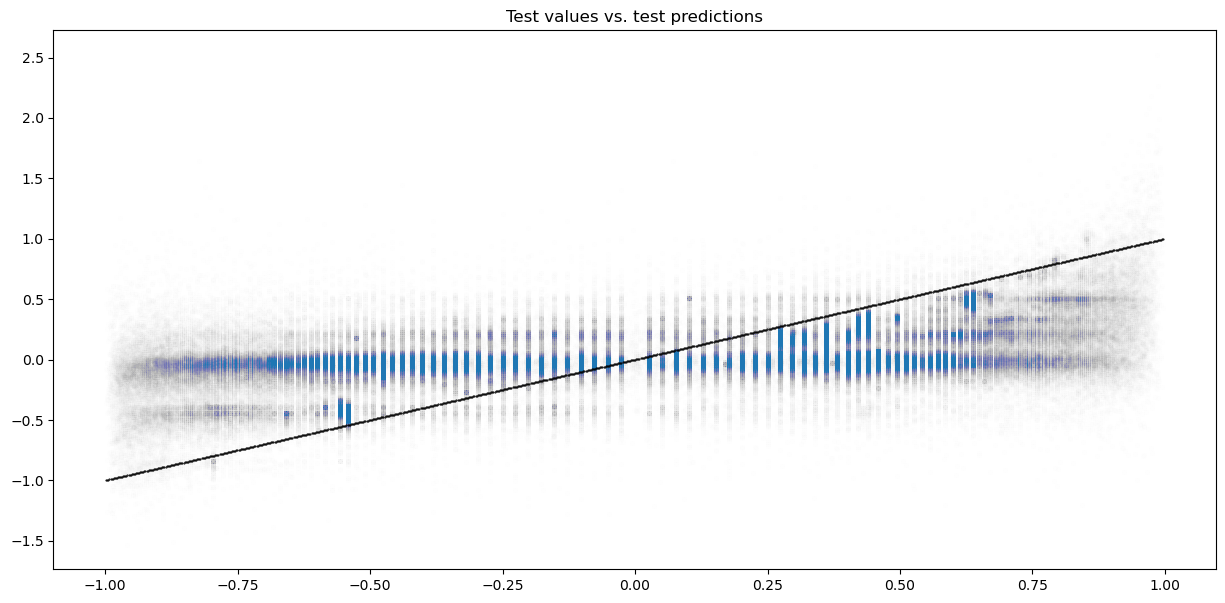

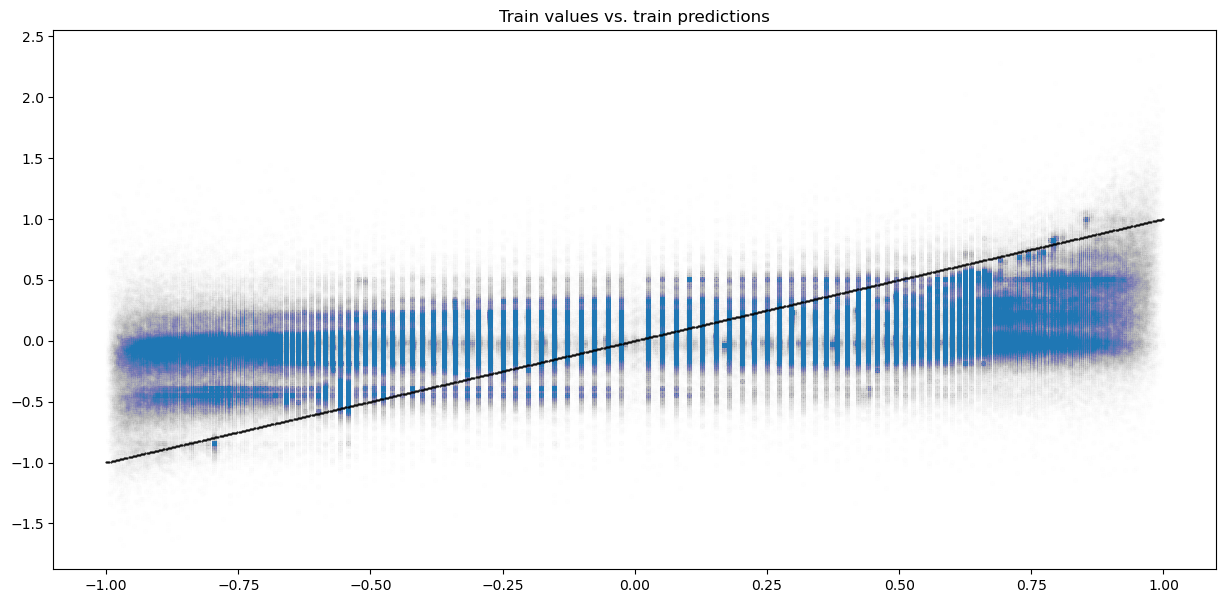

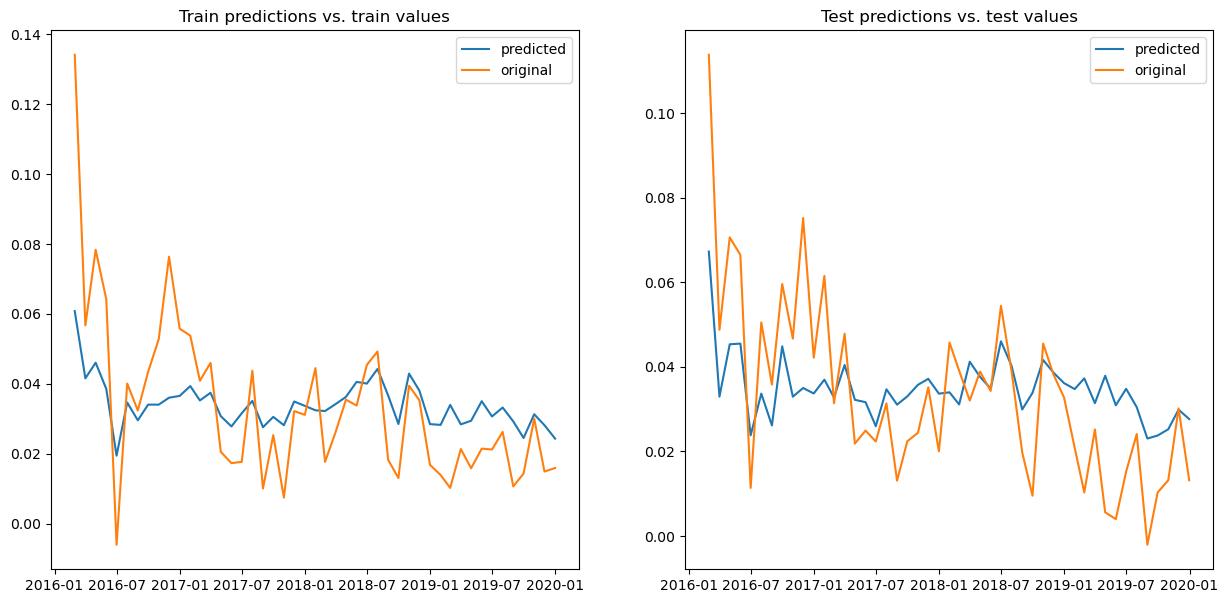

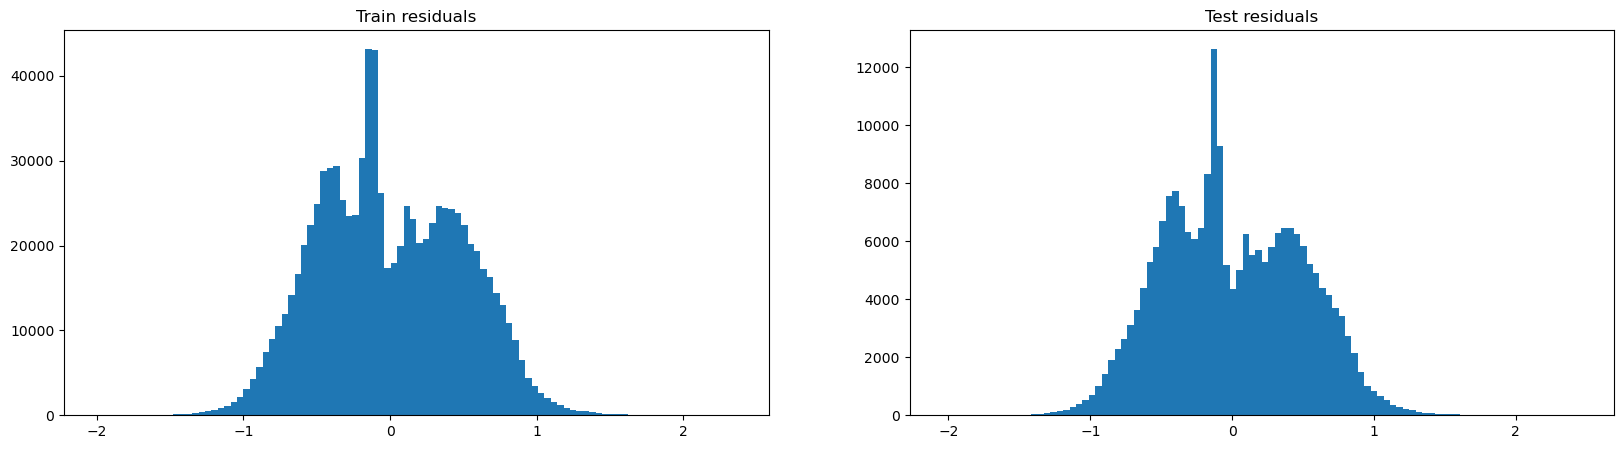

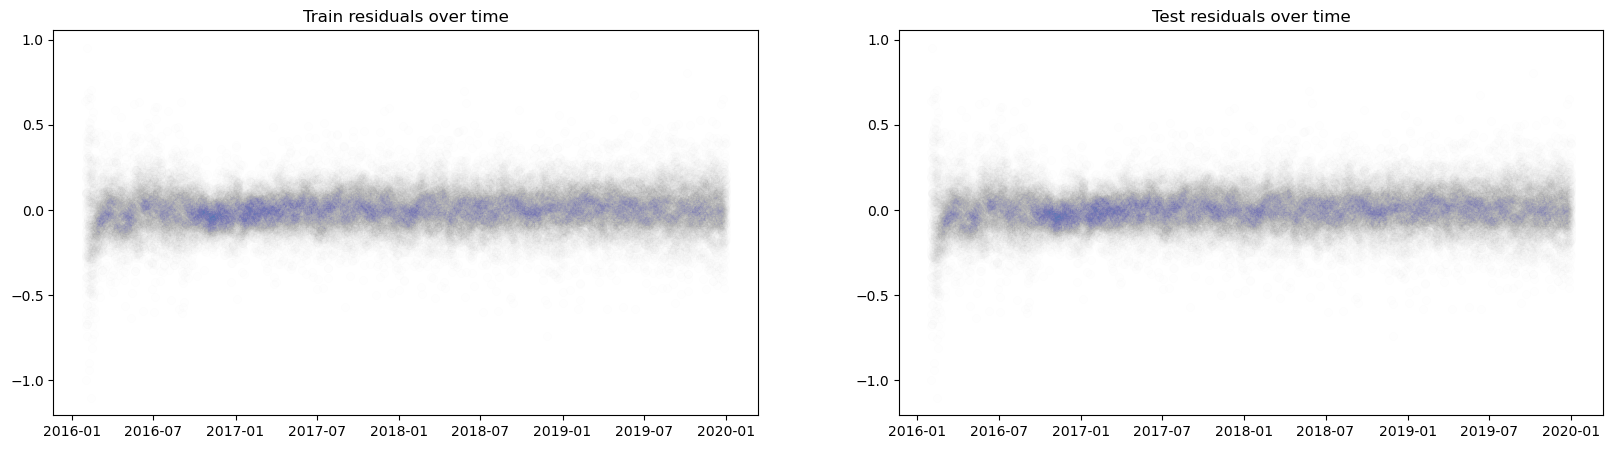

In [106]:
analyze_model(model7_results)

### Bigrams

In [89]:
y = vader[(vader.index.isin(bigram_features.index)) & (vader!=0)]
X = bigram_features[bigram_features.index.isin(y.index)]

In [90]:
model8_results = linear_model(X, y)

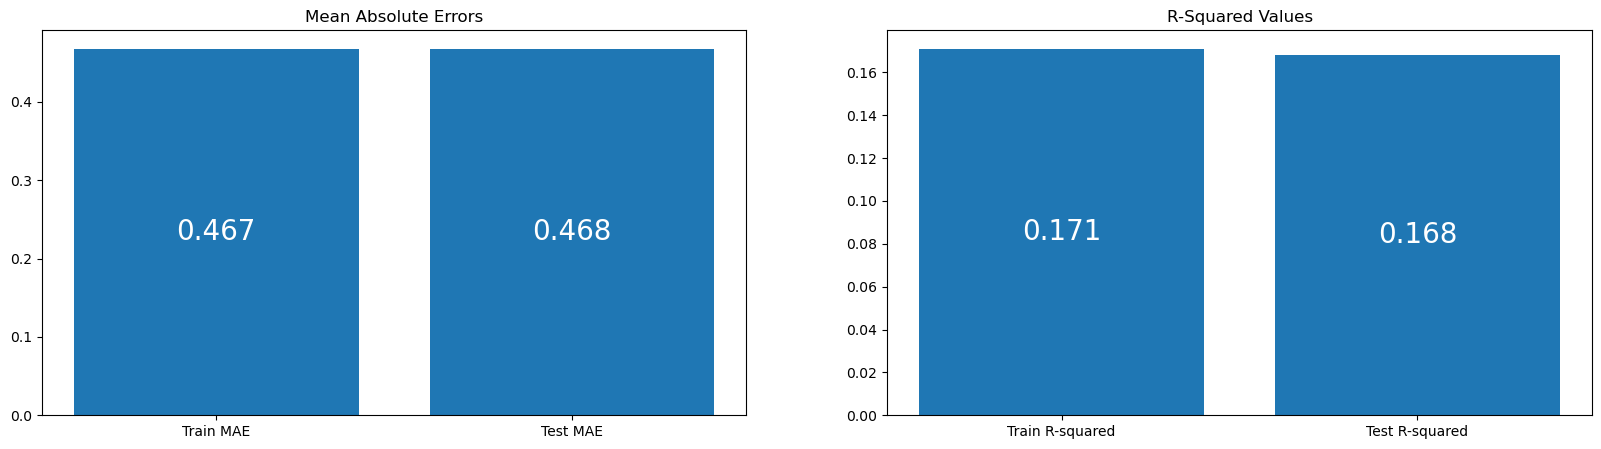

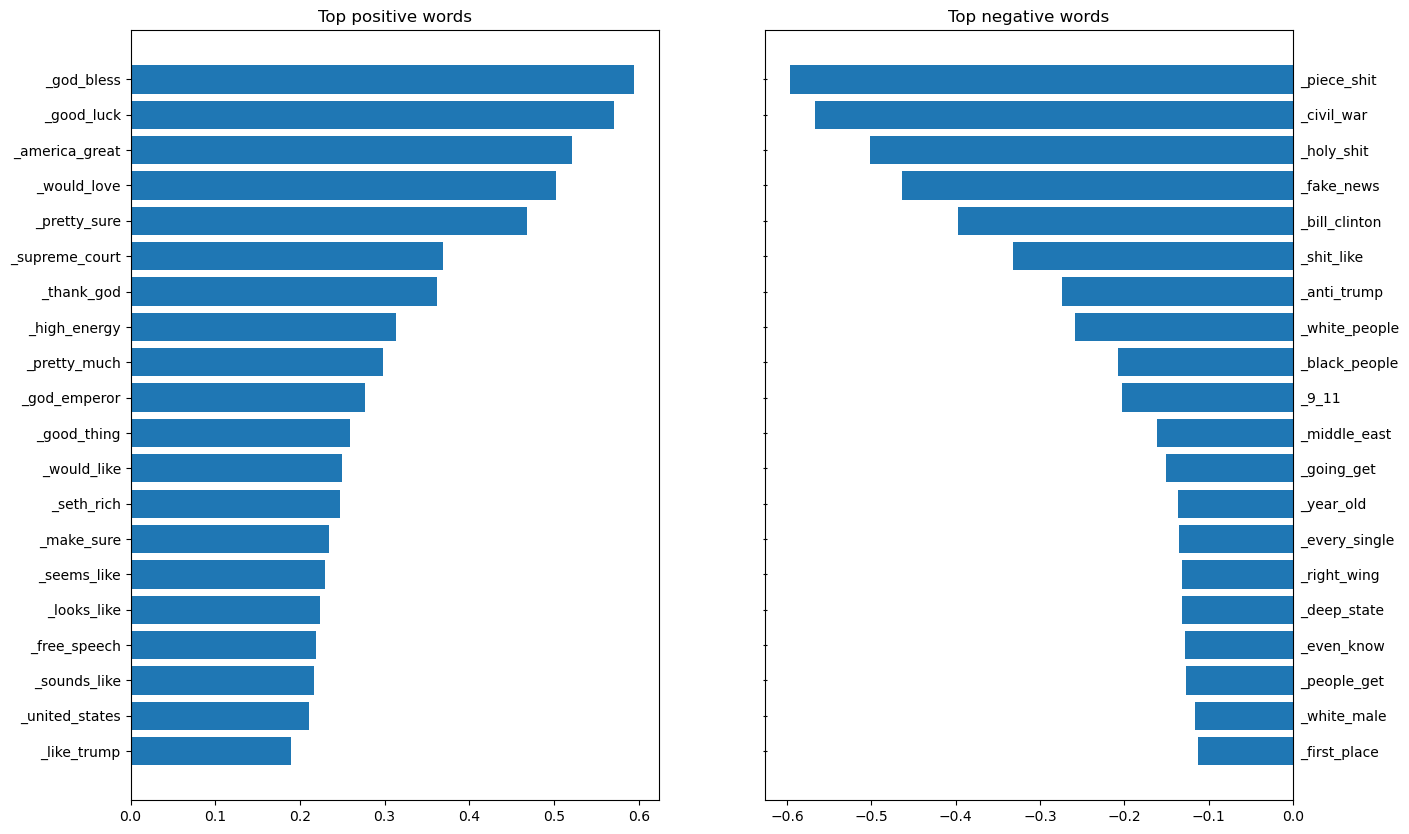

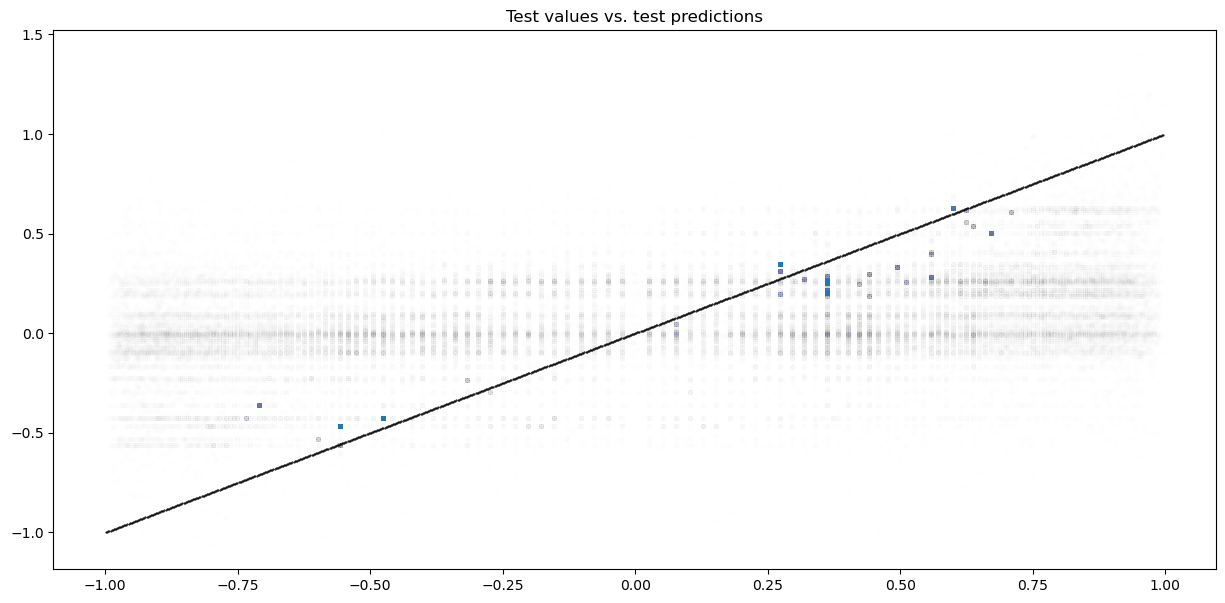

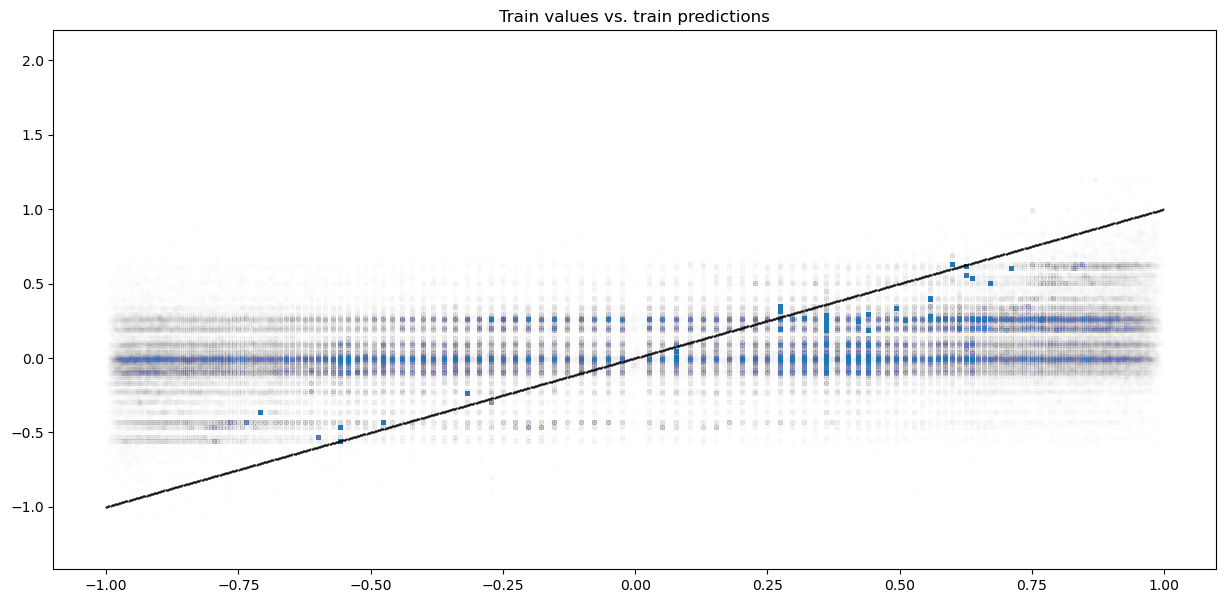

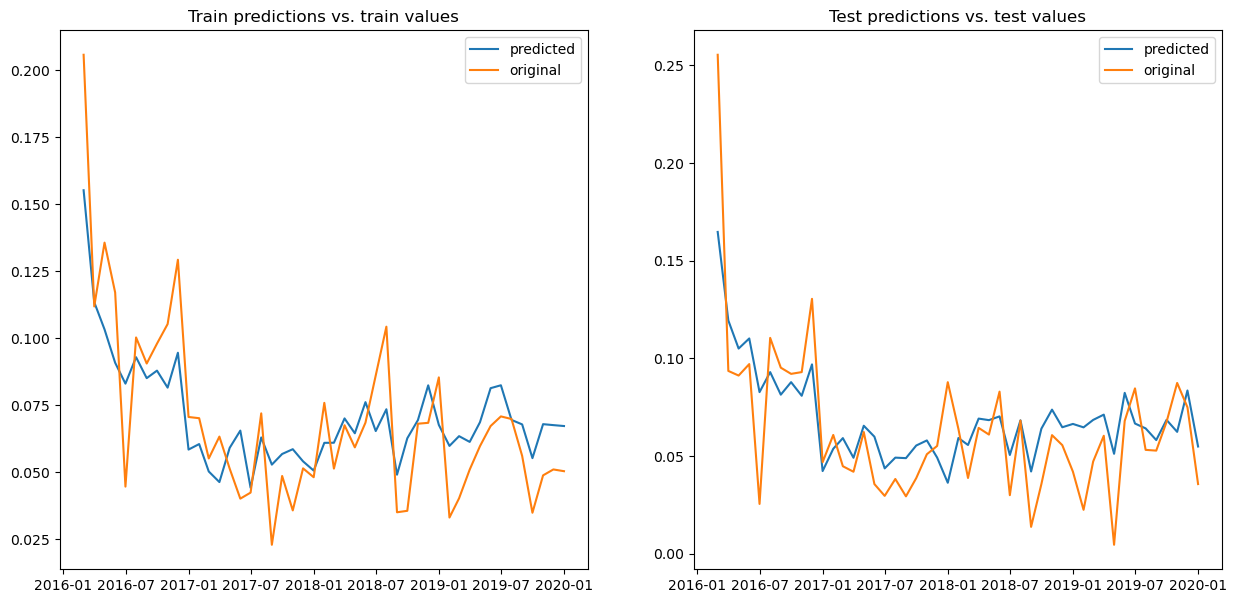

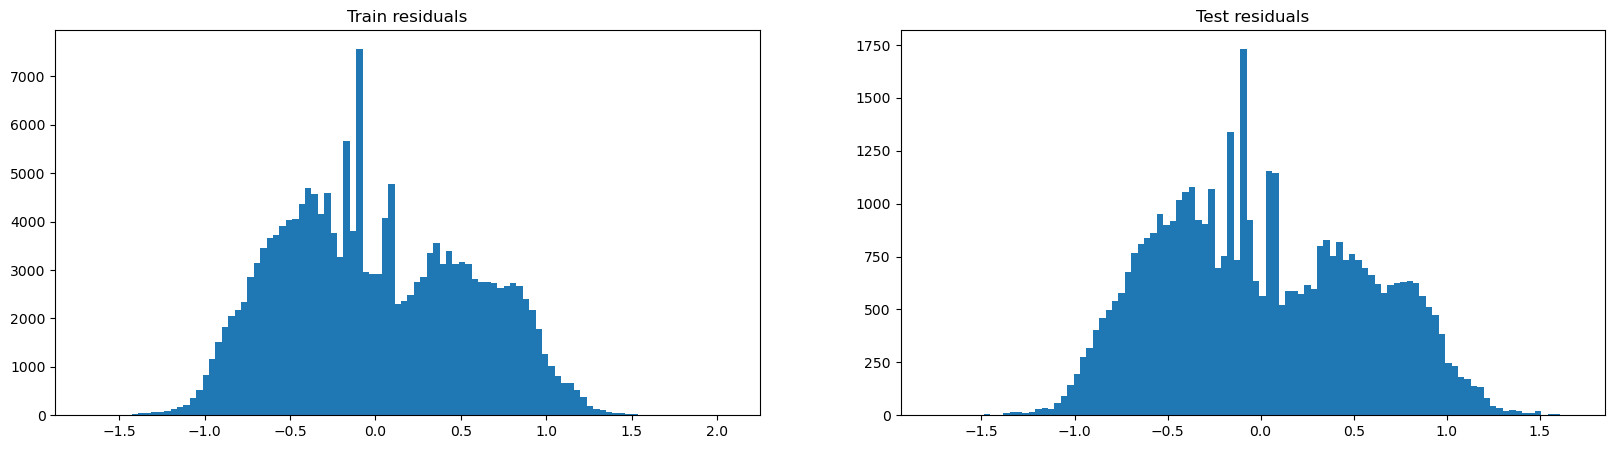

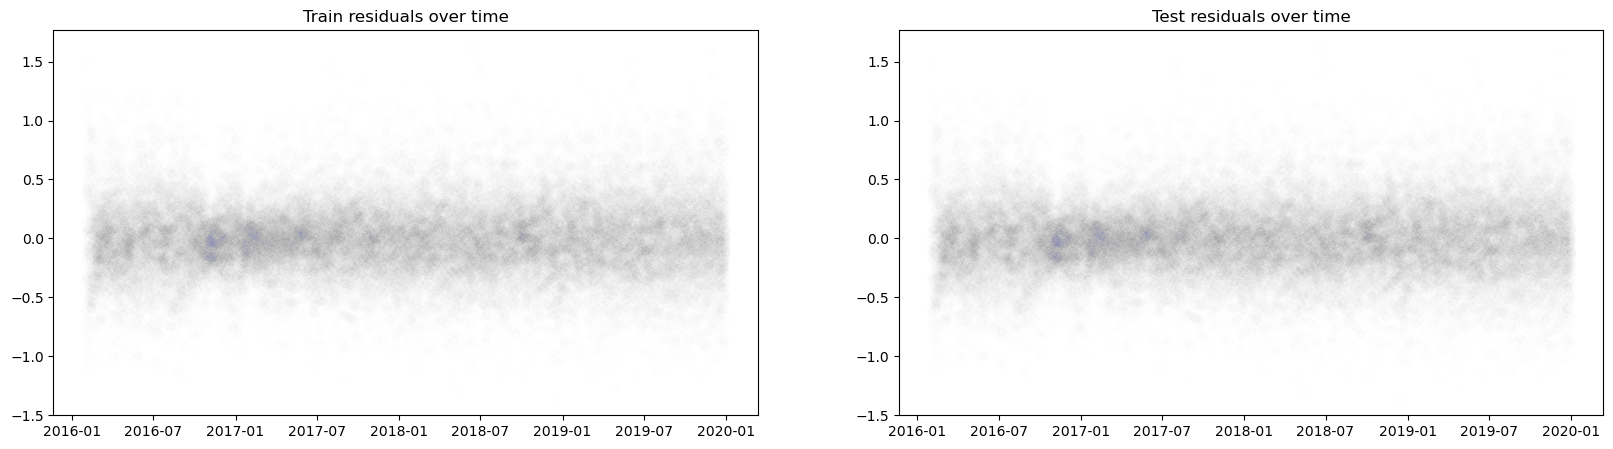

In [107]:
analyze_model(model8_results)

### Trigrams

In [92]:
y = vader[(vader.index.isin(trigram_features.index)) & (vader!=0)]
X = trigram_features[trigram_features.index.isin(y.index)]

In [93]:
model9_results = linear_model(X, y)

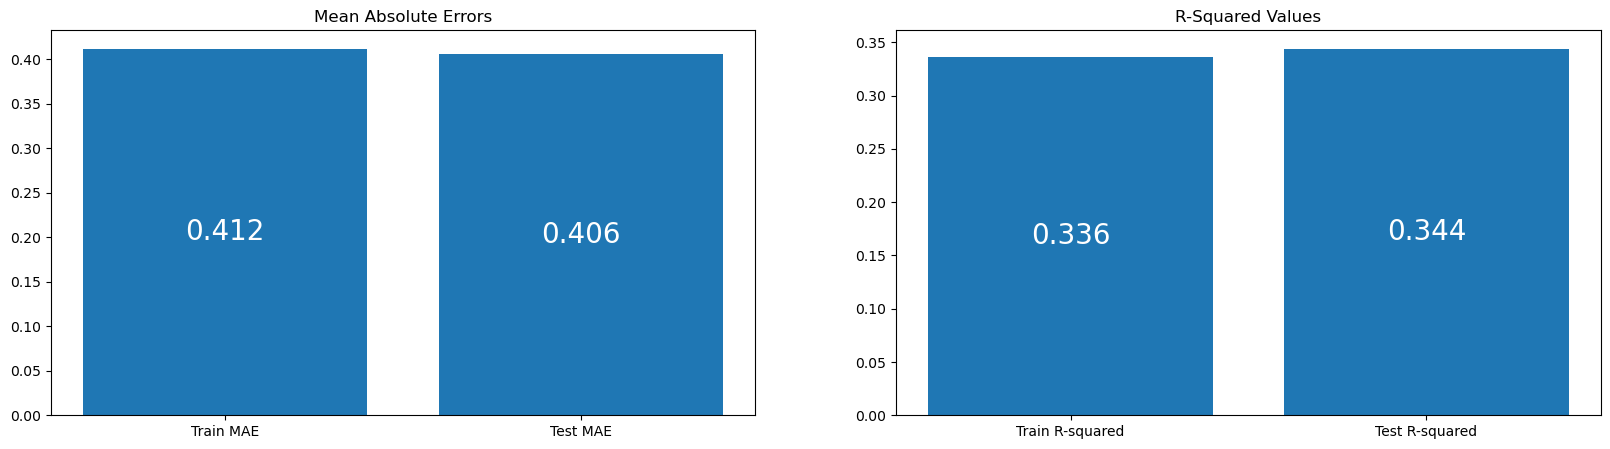

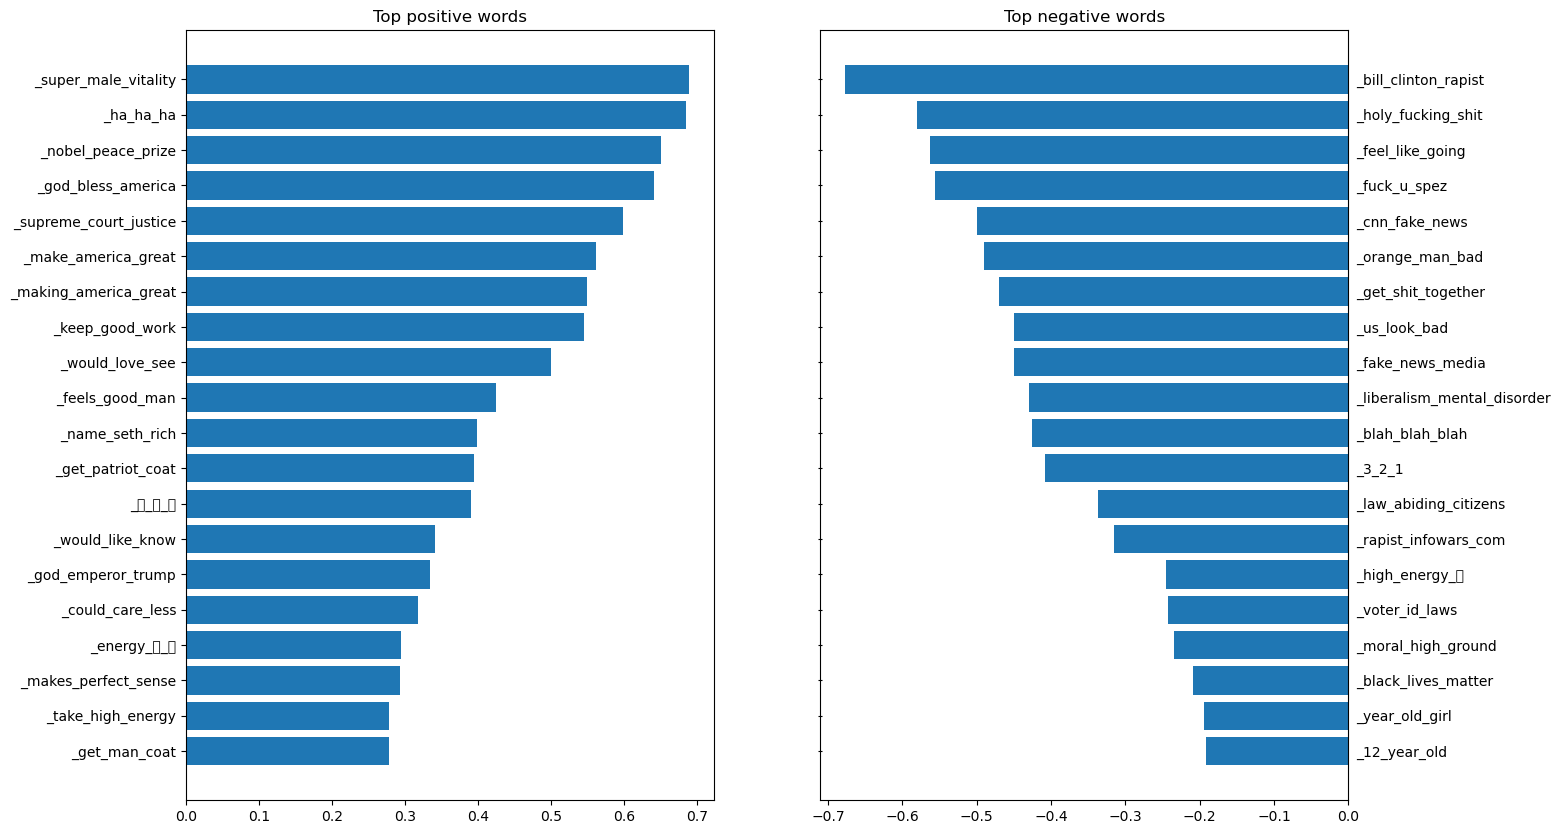

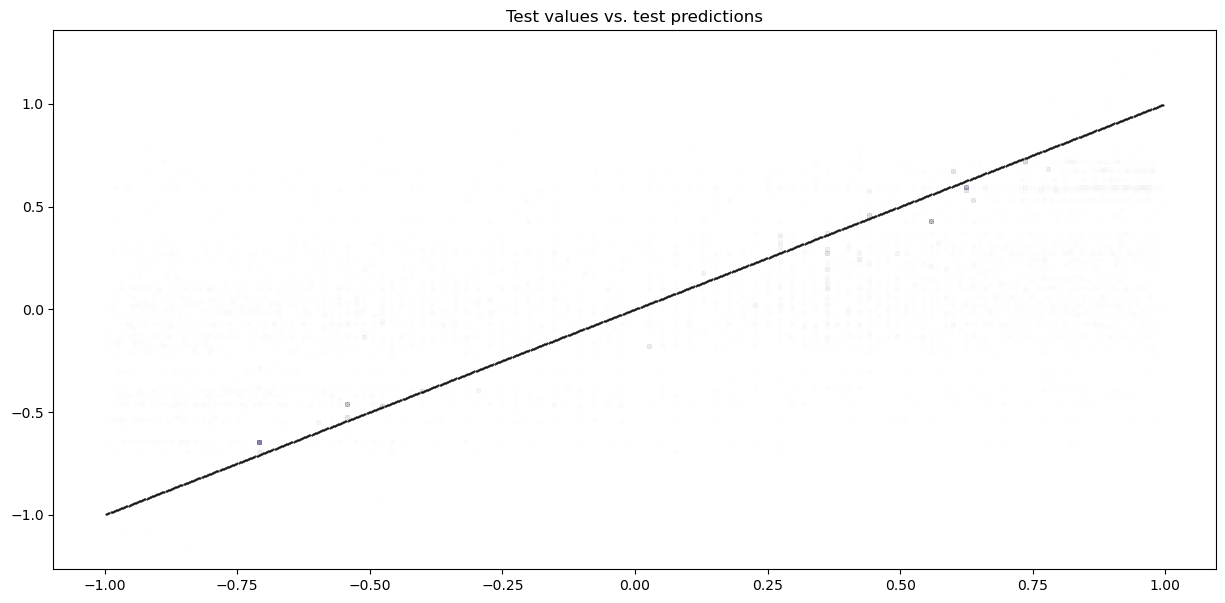

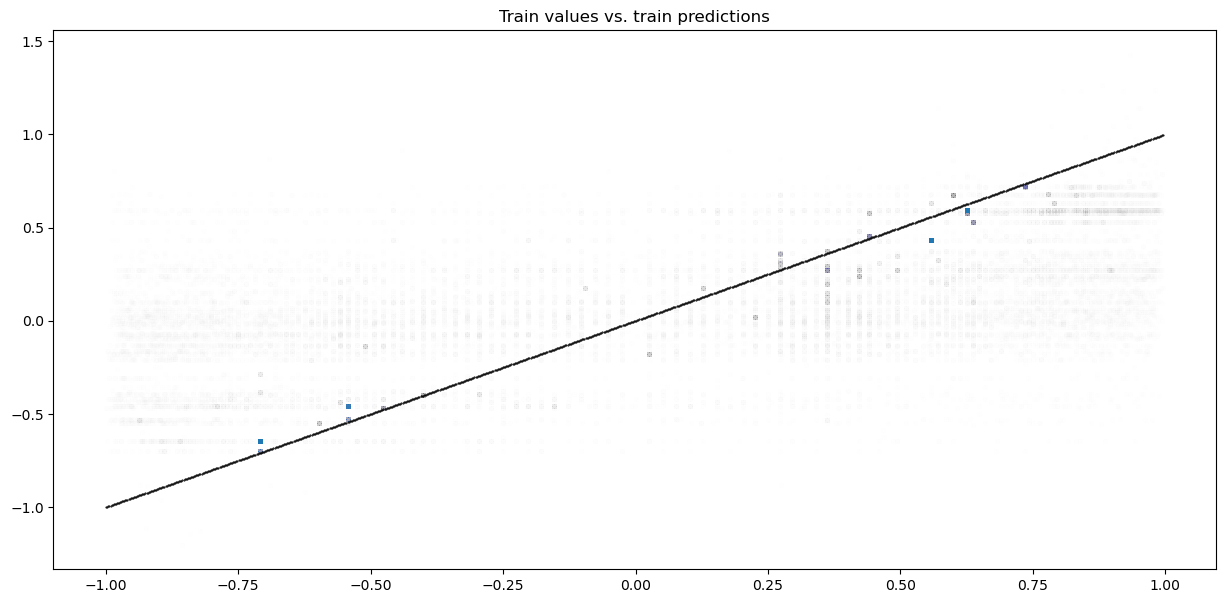

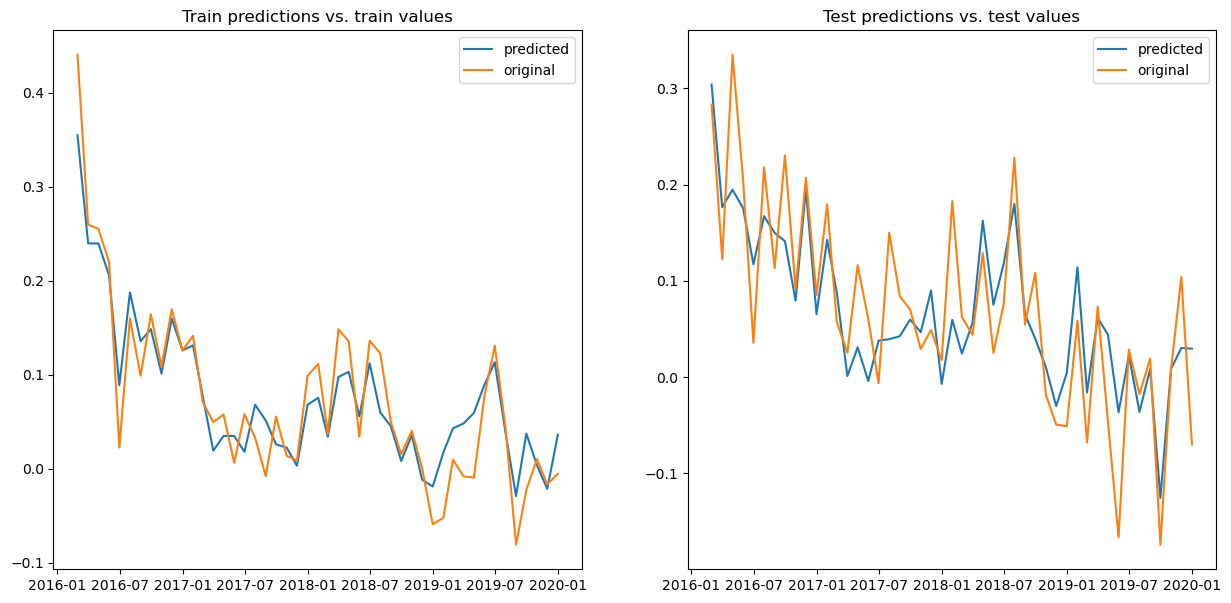

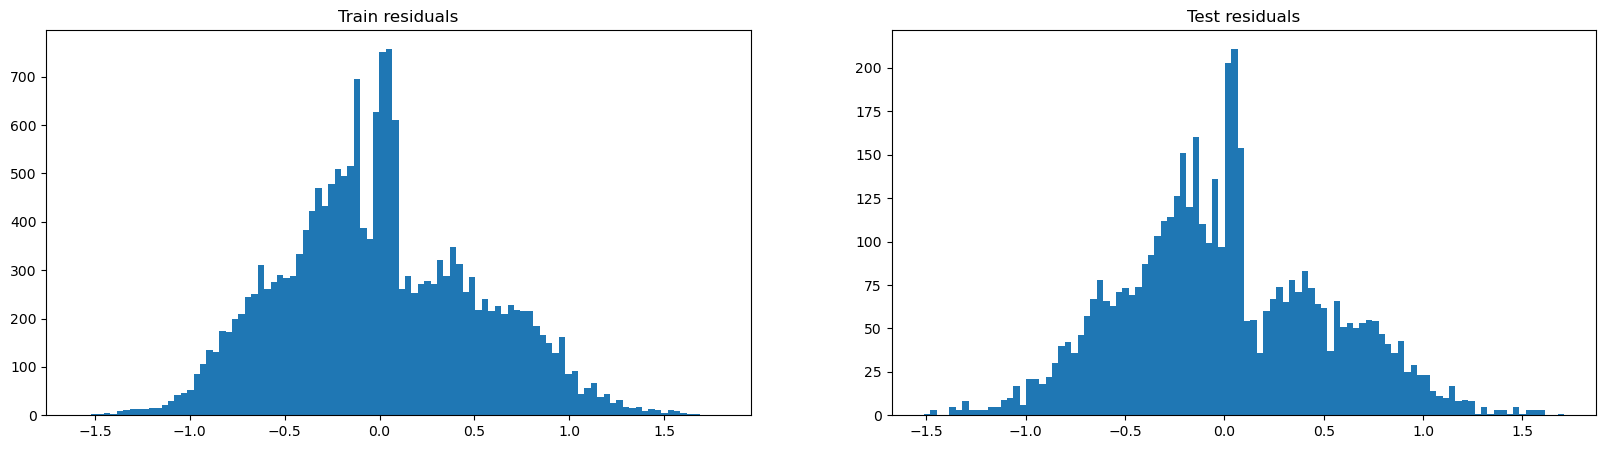

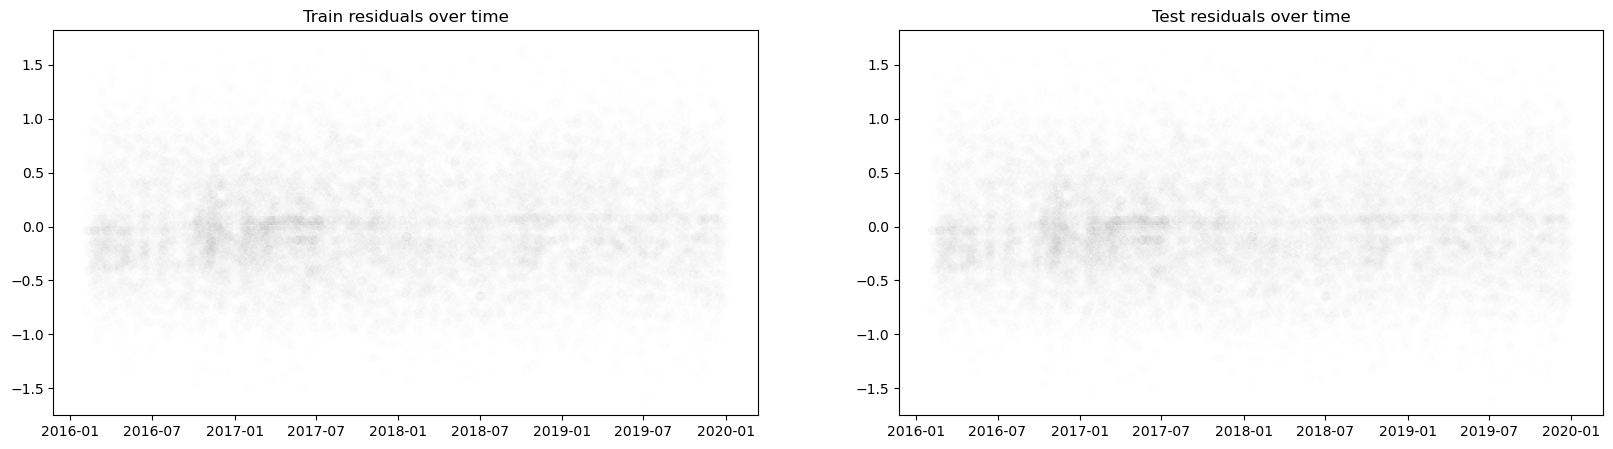

In [108]:
analyze_model(model9_results)

# Hyperparameter tuning

Our second model, with sentiment as a target variable, performed much better than our base model. We try some hyperparameter tuning for the unigram, bigram, and trigram model. Although the tuned models have better MAE scores on their training data, they do not have better MAE scores on the test data. Furthermore, all the top words are the same for the tuned models with only slight variations in how they are ordered.

I conclude that hyperparameter tuning did *not* improve our models and I will not be using them.

In [127]:
y = vader[(vader.index.isin(unigram_features.index)) & (vader!=0)]
X = unigram_features[unigram_features.index.isin(y.index)]
print("Hyperparameter tuning for unigrams...")
gridsearch1 = gridsearch(X, y)

y = vader[(vader.index.isin(bigram_features.index)) & (vader!=0)]
X = bigram_features[bigram_features.index.isin(y.index)]
print("Hyperparameter tuning for bigrams...")
gridsearch2 = gridsearch(X, y)

y = vader[(vader.index.isin(trigram_features.index)) & (vader!=0)]
X = trigram_features[trigram_features.index.isin(y.index)]
print("Hyperparameter tuning for trigrams...")
gridsearch3 = gridsearch(X, y)

In [128]:
print(f"test mae: {gridsearch1['test_mae']}, score to beat: {model7_results['test_mae']}")
print(f"test r2: {gridsearch1['test_r2']}, score to beat: {model7_results['test_r2']}")
gridsearch1['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.4081530891642157, score to beat: 0.40826588434892663
test r2: 0.2492208016705062, score to beat: 0.249428021535117


gram      coef
54    _great  0.500157
45     _love  0.498648
83     _best  0.491198
11     _good  0.341228
91   _pretty  0.335483
51      _lol  0.322907
64   _better  0.300506
28  _fucking  0.264472
0      _like  0.222362
88      _god  0.215390
90      _yes  0.202932
46     _sure  0.188249
21     _well  0.184938
72     _yeah  0.169808
93     _come  0.066611
19   _really  0.061542
94     _post  0.056049
2     _trump  0.047788
58     _work  0.047333
81     _give  0.045200

In [129]:
print(f"test mae: {gridsearch2['test_mae']}, score to beat: {model8_results['test_mae']}")
print(f"test r2: {gridsearch2['test_r2']}, score to beat: {model8_results['test_r2']}")
gridsearch2['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.4686803172050479, score to beat: 0.46771923366564544
test r2: 0.16754440904088574, score to beat: 0.16757422752968598


gram      coef
33      _god_bless  0.584280
84      _good_luck  0.550037
81     _would_love  0.486168
42  _america_great  0.478328
19    _pretty_sure  0.460358
67  _supreme_court  0.354748
89      _thank_god  0.346545
16    _high_energy  0.304017
14    _pretty_much  0.289774
39    _god_emperor  0.267443
44     _good_thing  0.252712
36     _would_like  0.243858
45      _seth_rich  0.236265
24      _make_sure  0.228422
11     _seems_like  0.222466
0      _looks_like  0.213242
28    _free_speech  0.211925
4     _sounds_like  0.210223
10  _united_states  0.206062
52     _like_trump  0.183728

In [130]:
print(f"test mae: {gridsearch3['test_mae']}, score to beat: {model9_results['test_mae']}")
print(f"test r2: {gridsearch3['test_r2']}, score to beat: {model9_results['test_r2']}")
gridsearch3['coefficients'].sort_values(by='coef', ascending=False).head(20)

test mae: 0.42355585075655205, score to beat: 0.4063716304334223
test r2: 0.3333129854291561, score to beat: 0.3435303643285402


gram      coef
23        _god_bless_america  0.529308
0        _make_america_great  0.525796
12     _making_america_great  0.487185
58      _super_male_vitality  0.478175
48        _nobel_peace_prize  0.466508
89    _supreme_court_justice  0.462580
30                 _ha_ha_ha  0.459190
10           _would_love_see  0.442030
52           _keep_good_work  0.381893
11           _name_seth_rich  0.339632
47           _feels_good_man  0.287046
61          _could_care_less  0.206226
76          _would_like_know  0.204610
15    _united_states_america  0.199732
28           _would_like_see  0.189495
92        _god_emperor_trump  0.189079
86        _pretty_much_every  0.181629
6   _president_united_states  0.179307
24         _get_patriot_coat  0.178275
3            _donald_j_trump  0.165182